<center>
<h1>Mustererkennung und Machine Learning</h1>

<h3> Wintersemester 2017/2018, 11th Exercise Sheet</h3>
<h4>Konstantin Jaehne, Luis Herrmann; Dozent: Raúl Rojas</h4>

<hr style='height:1px'>
</center>

In [11]:
import torch
torch.__version__

'0.3.0.post4'

# Assignment 1

Fill in the code and then print to PDF to send for marking.

## A first look at PyTorch


We will now take a look at a first concrete example of a neural network, which makes use of the Python library PyTorch to learn to classify fashion articles. Unless you already have experience with PyTorch or similar libraries, you will not understand everything about this first example right away. You probably haven't even installed Pytorch yet. Don't worry, that is perfectly fine. We will do all that below.

The problem we are trying to solve here is to classify grayscale images of fashion articles (28 pixels by 28 pixels), into their 10 categories. The dataset we will use is the Fashion-MNIST dataset, a dropin replacement of MNIST which is a classic dataset in the machine learning community, which has been around for almost as long as the field itself and has been very intensively studied. It's a set of 60,000 training images, plus 10,000 test images. You can think of "solving" Fashion-MNIST or MNIST as the "Hello World" of deep learning --- it's what you do to verify that your algorithms are working as expected. As you become a machine learning practitioner, you will see MNIST come up over and over again, in scientific papers, blog posts, and so on.

The Fashion-MNIST and MNIST datasets comes as standard datasets in PyTorch's `torchvision` library, as subclasses of `torch.utils.data.Dataset` which makes it convinent to use as we will see.

Our images are encoded as `PIL.Image.Image` objects, and the labels are simply an array of integers, ranging from 0 to 9.  There is a one-to-one correspondence between the images and the labels.

Before training, we will transform our data by first converting it to a `Tensor` and then  normalizing it so that all image values have mean 0.5 and standard deviation of 1, by composing these operations as `transforms` function to the datasets:

In [12]:
from torchvision import datasets, transforms

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

train_dataset = datasets.FashionMNIST('data', transform=trans, train=True, download=True)
test_dataset = datasets.FashionMNIST('data', transform=trans, train=False, download=True)

`train_dataset` forms the "training set", the data that the model will learn from. The model will then be tested on the "test set", `test_dataset`. 

Let's have a look at the training data:

In [13]:
len(train_dataset)

60000

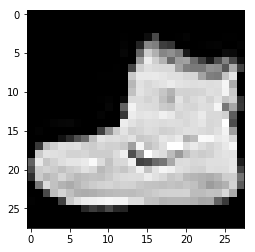

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(train_dataset.train_data[0], cmap='gray')

In [15]:
train_dataset.train_labels[0]

9

Let's have a look at the test data:

In [16]:
len(test_dataset)

10000

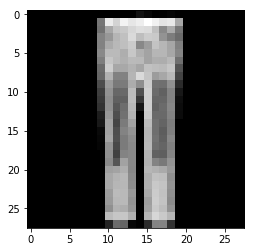

In [17]:
plt.imshow(test_dataset.test_data[15], cmap='gray')

In [18]:
test_dataset.test_labels[15]

1

Our workflow will be as follow: first we will present our neural network with the training data, `train_dataset` via the `DataLoader` iterator. The network will then learn to associate images and labels. Finally, we will ask the network to produce predictions for `test_dataset`, and we will verify if these predictions match the test labels.

Let's build our network --- again, remember that you aren't supposed to understand everything about this example just yet.

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)

In [20]:
model = Net()
if torch.cuda.is_available():
    model.cuda()

The core building block of neural networks is the "layer", a data-processing module which you can conceive as a "filter" for data. Some data comes in, and comes out in a more useful form. Precisely, layers extract _representations_ out of the data fed into them --- hopefully  representations that are more meaningful for the problem at hand. Most of deep learning really consists of chaining together simple layers  which will implement a form of progressive "data distillation". A deep learning model is like a sieve for data processing, made of a  succession of increasingly refined data filters --- the "layers".

Here our network consists of a sequence of two `Linear` layers, which are densely-connected (also called "fully-connected") neural layers.  The output (and last) layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each  score will be the probability that the current article image belongs to one of our 10 classes.

To make our network ready for training, we need to pick three more things:

* An optimizer: this is the mechanism through which the network will update itself based on the data it sees and its loss function.
* A loss function: the is how the network will be able to measure how good a job it is doing on its training data, and thus how it will be  able to steer itself in the right direction.
* Metrics to monitor during training and testing. Here we will only care about accuracy (the fraction of the images that were correctly classified).

The exact purpose of the loss function and the optimizer will be made clear throughout the next lectures and homeworks. Lets start with the optimizer:

In [21]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [22]:
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128, 
                                           shuffle=True,
                                           **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=128,
                                          shuffle=False,
                                          **kwargs)

We are now ready to train our network, meaning, we "fit" the model to its training data, which in PyTorch is done via a `train()`  helper which typically contains the loss we wish to minimize and looks like this: 

In [23]:
from torch.autograd import Variable

def train(epoch):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        
        output = model(data)
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

The quantity being displayed during training in the above helper is: the "loss" of the network over the training data. Let us write a `test()` helper which will print out the accuracy metric of the network over the test data:

In [24]:
def test():
    model.eval()
    
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Now let us  train the network for 5 epochs and print the test set accuracy at the end of each epoch:

In [25]:
for epoch in range(1, 5 + 1):
    train(epoch)
    test()

/home/herrmalu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.295490
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.171133
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.054397
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.956561
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.792852
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.697375
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.617221
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.510051
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.467023
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.325203
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.353551
Train Epoch: 1 [14080/60000 (23%)]	Loss: 1.258637
Train Epoch: 1 [15360/60000 (26%)]	Loss: 1.273790
Train Epoch: 1 [16640/60000 (28%)]	Loss: 1.106225
Train Epoch: 1 [17920/60000 (30%)]	Loss: 1.088401
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.075849
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.973698
Train Epoch: 1 [21760/60000 (36%)]	Loss: 1.065897
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.896731
Train Epoch: 1 [24320/60000 (41%)]	Loss: 0.995229
Train Epoch: 1 [

Process Process-1:
Traceback (most recent call last):
  File "/home/herrmalu/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/herrmalu/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py", line 42, in __call__
    img = t(img)
  File "/home/herrmalu/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/herrmalu/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 42, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/herrmalu/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 42, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/herrmalu/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/datasets/mnist.py", line 76, in __getitem__
    img = self.transfo

Train Epoch: 1 [33280/60000 (55%)]	Loss: 0.855206


  File "/home/herrmalu/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/functional.py", line 76, in to_tensor
    return img.float().div(255)


KeyboardInterrupt: 

  File "/home/herrmalu/anaconda3/lib/python3.6/site-packages/torch/tensor.py", line 43, in float
    return self.type(type(self).__module__ + '.FloatTensor')
  File "/home/herrmalu/anaconda3/lib/python3.6/site-packages/torch/_utils.py", line 38, in _type
    return new_type(self.size()).copy_(self, async)
KeyboardInterrupt


Our test set accuracy turns out to be 84% --- that's quite a bit lower than the training set accuracy.  This gap between training accuracy and test accuracy is an example of "overfitting",  the fact that machine learning models tend to perform worse on new data than on their training data.  Overfitting will be a central topic in machine learning and deep learning in particular.

This concludes our very first example --- you just saw how we could build and a train a neural network to classify clothing articles, in less than 30 or so lines of Python code.

## Assignment

In this assignment we will try to get some intuition on the hyperparameters associated with the optimizer. Optimization hyperparameters have a large influence on the quality of solutions found by optimization
algorithms for deep neural networks. The optimization algorithms we will look at have many hyperparameters:

* $\alpha_0$ the initial step size
* the step decay scheme
* $\beta_0$ the initial momentum value
* the momentum schedule
* ...

In this assignment we will concentrate on the the step size and the step decay scheme.

### Fixed Model

We will work with the following fixed model for the CIFAR-10 data:

In [26]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
}

class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        self.features = self._make_layers(cfg['VGG11'])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)
    
    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [27]:
model = VGG11()
if torch.cuda.is_available():
    model.cuda()

### Task 1

Load the CIFAR-10 dataset with some appropriate `batch_size` and transform it to a `Tensor` and normalize it using:

In [28]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [29]:
transformation = transforms.Compose([transforms.ToTensor(), normalize])

traindata = datasets.CIFAR10('data', transform=transformation, train=True, download=True)
testdata = datasets.CIFAR10('data', transform=transformation, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [30]:
traindata[0]

(
 (0 ,.,.) = 
  -1.1075 -1.3815 -1.2617  ...   0.5878  0.4851  0.4166
  -1.8439 -2.1179 -1.8097  ...  -0.0116 -0.0801 -0.0287
  -1.6898 -1.8439 -1.2788  ...  -0.0972 -0.0629 -0.2513
            ...             ⋱             ...          
   1.4440  1.3242  1.2728  ...   0.6221 -1.1589 -1.2103
   0.9646  0.8447  1.0673  ...   1.0331 -0.4568 -0.6965
   0.9132  0.7591  0.9474  ...   1.5810  0.4679 -0.0116
 
 (1 ,.,.) = 
  -0.9503 -1.2304 -1.1954  ...   0.2752  0.1527  0.1352
  -1.6856 -2.0357 -1.8957  ...  -0.4951 -0.5826 -0.5126
  -1.6155 -1.9132 -1.5630  ...  -0.5651 -0.5651 -0.7577
            ...             ⋱             ...          
   0.9405  0.6429  0.7829  ...   0.2927 -1.4930 -1.4405
   0.3978  0.1176  0.4853  ...   0.5553 -0.9503 -1.1078
   0.4853  0.2227  0.4503  ...   1.1856  0.0301 -0.4251
 
 (2 ,.,.) = 
  -0.7064 -1.0201 -1.0550  ...   0.0779 -0.0267 -0.0092
  -1.4559 -1.8044 -1.8044  ...  -0.8458 -0.9330 -0.8110
  -1.4384 -1.8044 -1.6650  ...  -0.9330 -0.9330 -1.0724
   

### Task 2

Next we want to train the network by minimizing the `CrossEntropyLoss` for `50` epochs using the `SGD` and `Adam` optimizer using their default parameters and plot the validation accuracy and test accuracy over the course of the training.

Having defined these, we introduce a new `train()` and `test()` function:

In [92]:
import matplotlib.pyplot as plt

class NNRunner:
    def __init__(self, traindata, testdata, optimizer, oparams={}, scheduler=None, sparams={}):
        kwargs_loader = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
        self.trainld = torch.utils.data.DataLoader(traindata,
                                           batch_size=128, 
                                           shuffle=True,
                                           **kwargs_loader)
        self.testld = torch.utils.data.DataLoader(testdata,
                                                  batch_size=128,
                                                  shuffle=False,
                                                  **kwargs_loader)
        self.train_samples = len(traindata)
        self.test_samples = len(testdata)
        self.model = VGG11()
        if torch.cuda.is_available():
            self.model.cuda()
        self.optimizer = optimizer(self.model.parameters(), **oparams)
        if(not(scheduler is None)):
            self.scheduler = scheduler(self.optimizer, **sparams)
        else:
            self.scheduler = None

    def train(self, epoch):
        self.model.train()
        correct = 0
        avg_loss = 0
        for batch_idx, (data, target) in enumerate(self.trainld):
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            self.optimizer.zero_grad()
            output = self.model(data)
            loss = F.cross_entropy(output, target)#formerly F.nll_loss
            avg_loss += float(loss)
            loss.backward()
            pred = output.data.max(dim=1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
            self.optimizer.step()

            if batch_idx % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(self.trainld.dataset),
                    100. * batch_idx / len(self.trainld), loss.data[0]))
        
        avg_loss /= len(self.trainld)
        if(not(self.scheduler is None)):
            self.scheduler.step(avg_loss)
        accuracy = 100. * correct / self.train_samples
        print('\nTraining set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(avg_loss,
                                                                                       correct, 
                                                                                       self.train_samples, 
                                                                                       accuracy))
        return(accuracy)
            
    def test(self):
        self.model.eval()

        test_loss = 0
        correct = 0
        for data, target in self.testld:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data, volatile=True), Variable(target)
            output = self.model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).data[0] # sum up batch loss
            pred = output.data.max(dim=1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        test_loss /= len(self.testld.dataset)
        accuracy = 100. * correct / len(self.testld.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(self.testld.dataset),
            accuracy))
        return(accuracy)
    
    def run(self, epoch=10):
        accuracy = [[],[]]
        for i in range(1, epoch+1):
            validator_acc = self.train(i)
            test_acc = self.test()
            accuracy[0].append(validator_acc)
            accuracy[1].append(test_acc)
        return(accuracy)

In [93]:
SGDR= NNRunner(traindata, testdata, optim.SGD, {'lr' : 0.1}, )
SGDacc = SGDR.run(epoch=50)
AdamR = NNRunner(traindata, testdata, optim.Adam)
Adamacc = AdamR.run(epoch=50)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.373658
Train Epoch: 1 [1280/50000 (3%)]	Loss: 2.362364
Train Epoch: 1 [2560/50000 (5%)]	Loss: 1.943431
Train Epoch: 1 [3840/50000 (8%)]	Loss: 1.797888
Train Epoch: 1 [5120/50000 (10%)]	Loss: 1.734363
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.681383
Train Epoch: 1 [7680/50000 (15%)]	Loss: 1.669143
Train Epoch: 1 [8960/50000 (18%)]	Loss: 1.584785
Train Epoch: 1 [10240/50000 (20%)]	Loss: 1.432323
Train Epoch: 1 [11520/50000 (23%)]	Loss: 1.460642
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.584537
Train Epoch: 1 [14080/50000 (28%)]	Loss: 1.437812
Train Epoch: 1 [15360/50000 (31%)]	Loss: 1.405299
Train Epoch: 1 [16640/50000 (33%)]	Loss: 1.498504
Train Epoch: 1 [17920/50000 (36%)]	Loss: 1.394084
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.410848
Train Epoch: 1 [20480/50000 (41%)]	Loss: 1.315349
Train Epoch: 1 [21760/50000 (43%)]	Loss: 1.476502
Train Epoch: 1 [23040/50000 (46%)]	Loss: 1.168609
Train Epoch: 1 [24320/50000 (49%)]	Loss: 1.348631
Train Epoch: 1 

Train Epoch: 4 [48640/50000 (97%)]	Loss: 0.401171
Train Epoch: 4 [31200/50000 (100%)]	Loss: 0.614040

Training set: Average loss: 0.4945, Accuracy: 41460/50000 (83%)

Test set: Average loss: 1.0105, Accuracy: 6841/10000 (68%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 0.272485
Train Epoch: 5 [1280/50000 (3%)]	Loss: 0.451427
Train Epoch: 5 [2560/50000 (5%)]	Loss: 0.313472
Train Epoch: 5 [3840/50000 (8%)]	Loss: 0.279154
Train Epoch: 5 [5120/50000 (10%)]	Loss: 0.284465
Train Epoch: 5 [6400/50000 (13%)]	Loss: 0.483834
Train Epoch: 5 [7680/50000 (15%)]	Loss: 0.494650
Train Epoch: 5 [8960/50000 (18%)]	Loss: 0.339890
Train Epoch: 5 [10240/50000 (20%)]	Loss: 0.266158
Train Epoch: 5 [11520/50000 (23%)]	Loss: 0.345167
Train Epoch: 5 [12800/50000 (26%)]	Loss: 0.328907
Train Epoch: 5 [14080/50000 (28%)]	Loss: 0.191305
Train Epoch: 5 [15360/50000 (31%)]	Loss: 0.595769
Train Epoch: 5 [16640/50000 (33%)]	Loss: 0.354483
Train Epoch: 5 [17920/50000 (36%)]	Loss: 0.365408
Train Epoch: 5 [19200/50000 (38%)]	Los

Train Epoch: 8 [42240/50000 (84%)]	Loss: 0.255527
Train Epoch: 8 [43520/50000 (87%)]	Loss: 0.178712
Train Epoch: 8 [44800/50000 (90%)]	Loss: 0.260649
Train Epoch: 8 [46080/50000 (92%)]	Loss: 0.095800
Train Epoch: 8 [47360/50000 (95%)]	Loss: 0.199041
Train Epoch: 8 [48640/50000 (97%)]	Loss: 0.129347
Train Epoch: 8 [31200/50000 (100%)]	Loss: 0.199040

Training set: Average loss: 0.1649, Accuracy: 47121/50000 (94%)

Test set: Average loss: 0.9971, Accuracy: 7388/10000 (74%)

Train Epoch: 9 [0/50000 (0%)]	Loss: 0.143910
Train Epoch: 9 [1280/50000 (3%)]	Loss: 0.087979
Train Epoch: 9 [2560/50000 (5%)]	Loss: 0.040723
Train Epoch: 9 [3840/50000 (8%)]	Loss: 0.043972
Train Epoch: 9 [5120/50000 (10%)]	Loss: 0.097665
Train Epoch: 9 [6400/50000 (13%)]	Loss: 0.073827
Train Epoch: 9 [7680/50000 (15%)]	Loss: 0.161414
Train Epoch: 9 [8960/50000 (18%)]	Loss: 0.140587
Train Epoch: 9 [10240/50000 (20%)]	Loss: 0.117542
Train Epoch: 9 [11520/50000 (23%)]	Loss: 0.042521
Train Epoch: 9 [12800/50000 (26%)]	Los

Train Epoch: 12 [33280/50000 (66%)]	Loss: 0.021749
Train Epoch: 12 [34560/50000 (69%)]	Loss: 0.041603
Train Epoch: 12 [35840/50000 (72%)]	Loss: 0.086333
Train Epoch: 12 [37120/50000 (74%)]	Loss: 0.028633
Train Epoch: 12 [38400/50000 (77%)]	Loss: 0.033701
Train Epoch: 12 [39680/50000 (79%)]	Loss: 0.046257
Train Epoch: 12 [40960/50000 (82%)]	Loss: 0.051730
Train Epoch: 12 [42240/50000 (84%)]	Loss: 0.026978
Train Epoch: 12 [43520/50000 (87%)]	Loss: 0.040686
Train Epoch: 12 [44800/50000 (90%)]	Loss: 0.042406
Train Epoch: 12 [46080/50000 (92%)]	Loss: 0.024417
Train Epoch: 12 [47360/50000 (95%)]	Loss: 0.057812
Train Epoch: 12 [48640/50000 (97%)]	Loss: 0.024269
Train Epoch: 12 [31200/50000 (100%)]	Loss: 0.043829

Training set: Average loss: 0.0485, Accuracy: 49192/50000 (98%)

Test set: Average loss: 0.8735, Accuracy: 8103/10000 (81%)

Train Epoch: 13 [0/50000 (0%)]	Loss: 0.044205
Train Epoch: 13 [1280/50000 (3%)]	Loss: 0.057874
Train Epoch: 13 [2560/50000 (5%)]	Loss: 0.037319
Train Epoch: 13

Train Epoch: 16 [23040/50000 (46%)]	Loss: 0.014365
Train Epoch: 16 [24320/50000 (49%)]	Loss: 0.004335
Train Epoch: 16 [25600/50000 (51%)]	Loss: 0.009140
Train Epoch: 16 [26880/50000 (54%)]	Loss: 0.013755
Train Epoch: 16 [28160/50000 (56%)]	Loss: 0.003331
Train Epoch: 16 [29440/50000 (59%)]	Loss: 0.005377
Train Epoch: 16 [30720/50000 (61%)]	Loss: 0.002150
Train Epoch: 16 [32000/50000 (64%)]	Loss: 0.029533
Train Epoch: 16 [33280/50000 (66%)]	Loss: 0.035386
Train Epoch: 16 [34560/50000 (69%)]	Loss: 0.010632
Train Epoch: 16 [35840/50000 (72%)]	Loss: 0.051109
Train Epoch: 16 [37120/50000 (74%)]	Loss: 0.024115
Train Epoch: 16 [38400/50000 (77%)]	Loss: 0.004415
Train Epoch: 16 [39680/50000 (79%)]	Loss: 0.019319
Train Epoch: 16 [40960/50000 (82%)]	Loss: 0.009127
Train Epoch: 16 [42240/50000 (84%)]	Loss: 0.037208
Train Epoch: 16 [43520/50000 (87%)]	Loss: 0.004377
Train Epoch: 16 [44800/50000 (90%)]	Loss: 0.057927
Train Epoch: 16 [46080/50000 (92%)]	Loss: 0.040983
Train Epoch: 16 [47360/50000 (9

Train Epoch: 20 [12800/50000 (26%)]	Loss: 0.003706
Train Epoch: 20 [14080/50000 (28%)]	Loss: 0.024517
Train Epoch: 20 [15360/50000 (31%)]	Loss: 0.009930
Train Epoch: 20 [16640/50000 (33%)]	Loss: 0.004951
Train Epoch: 20 [17920/50000 (36%)]	Loss: 0.004803
Train Epoch: 20 [19200/50000 (38%)]	Loss: 0.006525
Train Epoch: 20 [20480/50000 (41%)]	Loss: 0.027979
Train Epoch: 20 [21760/50000 (43%)]	Loss: 0.004450
Train Epoch: 20 [23040/50000 (46%)]	Loss: 0.018501
Train Epoch: 20 [24320/50000 (49%)]	Loss: 0.008399
Train Epoch: 20 [25600/50000 (51%)]	Loss: 0.030511
Train Epoch: 20 [26880/50000 (54%)]	Loss: 0.005187
Train Epoch: 20 [28160/50000 (56%)]	Loss: 0.057970
Train Epoch: 20 [29440/50000 (59%)]	Loss: 0.031207
Train Epoch: 20 [30720/50000 (61%)]	Loss: 0.004903
Train Epoch: 20 [32000/50000 (64%)]	Loss: 0.004902
Train Epoch: 20 [33280/50000 (66%)]	Loss: 0.014515
Train Epoch: 20 [34560/50000 (69%)]	Loss: 0.004248
Train Epoch: 20 [35840/50000 (72%)]	Loss: 0.016980
Train Epoch: 20 [37120/50000 (7

Train Epoch: 24 [2560/50000 (5%)]	Loss: 0.000416
Train Epoch: 24 [3840/50000 (8%)]	Loss: 0.000095
Train Epoch: 24 [5120/50000 (10%)]	Loss: 0.000220
Train Epoch: 24 [6400/50000 (13%)]	Loss: 0.000191
Train Epoch: 24 [7680/50000 (15%)]	Loss: 0.000626
Train Epoch: 24 [8960/50000 (18%)]	Loss: 0.000279
Train Epoch: 24 [10240/50000 (20%)]	Loss: 0.000171
Train Epoch: 24 [11520/50000 (23%)]	Loss: 0.000206
Train Epoch: 24 [12800/50000 (26%)]	Loss: 0.000063
Train Epoch: 24 [14080/50000 (28%)]	Loss: 0.000191
Train Epoch: 24 [15360/50000 (31%)]	Loss: 0.000275
Train Epoch: 24 [16640/50000 (33%)]	Loss: 0.000502
Train Epoch: 24 [17920/50000 (36%)]	Loss: 0.000215
Train Epoch: 24 [19200/50000 (38%)]	Loss: 0.000268
Train Epoch: 24 [20480/50000 (41%)]	Loss: 0.000109
Train Epoch: 24 [21760/50000 (43%)]	Loss: 0.000368
Train Epoch: 24 [23040/50000 (46%)]	Loss: 0.000171
Train Epoch: 24 [24320/50000 (49%)]	Loss: 0.000256
Train Epoch: 24 [25600/50000 (51%)]	Loss: 0.000115
Train Epoch: 24 [26880/50000 (54%)]	Los

Train Epoch: 27 [47360/50000 (95%)]	Loss: 0.000048
Train Epoch: 27 [48640/50000 (97%)]	Loss: 0.000068
Train Epoch: 27 [31200/50000 (100%)]	Loss: 0.000276

Training set: Average loss: 0.0002, Accuracy: 50000/50000 (100%)

Test set: Average loss: 0.8942, Accuracy: 8434/10000 (84%)

Train Epoch: 28 [0/50000 (0%)]	Loss: 0.000239
Train Epoch: 28 [1280/50000 (3%)]	Loss: 0.000211
Train Epoch: 28 [2560/50000 (5%)]	Loss: 0.000057
Train Epoch: 28 [3840/50000 (8%)]	Loss: 0.000146
Train Epoch: 28 [5120/50000 (10%)]	Loss: 0.000334
Train Epoch: 28 [6400/50000 (13%)]	Loss: 0.000081
Train Epoch: 28 [7680/50000 (15%)]	Loss: 0.000088
Train Epoch: 28 [8960/50000 (18%)]	Loss: 0.000065
Train Epoch: 28 [10240/50000 (20%)]	Loss: 0.000061
Train Epoch: 28 [11520/50000 (23%)]	Loss: 0.000101
Train Epoch: 28 [12800/50000 (26%)]	Loss: 0.000080
Train Epoch: 28 [14080/50000 (28%)]	Loss: 0.000045
Train Epoch: 28 [15360/50000 (31%)]	Loss: 0.000174
Train Epoch: 28 [16640/50000 (33%)]	Loss: 0.000143
Train Epoch: 28 [179

Train Epoch: 31 [37120/50000 (74%)]	Loss: 0.000052
Train Epoch: 31 [38400/50000 (77%)]	Loss: 0.000143
Train Epoch: 31 [39680/50000 (79%)]	Loss: 0.000043
Train Epoch: 31 [40960/50000 (82%)]	Loss: 0.000040
Train Epoch: 31 [42240/50000 (84%)]	Loss: 0.000045
Train Epoch: 31 [43520/50000 (87%)]	Loss: 0.000045
Train Epoch: 31 [44800/50000 (90%)]	Loss: 0.000143
Train Epoch: 31 [46080/50000 (92%)]	Loss: 0.000186
Train Epoch: 31 [47360/50000 (95%)]	Loss: 0.000051
Train Epoch: 31 [48640/50000 (97%)]	Loss: 0.000215
Train Epoch: 31 [31200/50000 (100%)]	Loss: 0.000081

Training set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Test set: Average loss: 0.9152, Accuracy: 8421/10000 (84%)

Train Epoch: 32 [0/50000 (0%)]	Loss: 0.000033
Train Epoch: 32 [1280/50000 (3%)]	Loss: 0.000125
Train Epoch: 32 [2560/50000 (5%)]	Loss: 0.000364
Train Epoch: 32 [3840/50000 (8%)]	Loss: 0.000028
Train Epoch: 32 [5120/50000 (10%)]	Loss: 0.000088
Train Epoch: 32 [6400/50000 (13%)]	Loss: 0.000091
Train Epoch: 32 [7

Train Epoch: 35 [26880/50000 (54%)]	Loss: 0.000176
Train Epoch: 35 [28160/50000 (56%)]	Loss: 0.000042
Train Epoch: 35 [29440/50000 (59%)]	Loss: 0.000024
Train Epoch: 35 [30720/50000 (61%)]	Loss: 0.000046
Train Epoch: 35 [32000/50000 (64%)]	Loss: 0.000052
Train Epoch: 35 [33280/50000 (66%)]	Loss: 0.000059
Train Epoch: 35 [34560/50000 (69%)]	Loss: 0.000087
Train Epoch: 35 [35840/50000 (72%)]	Loss: 0.000054
Train Epoch: 35 [37120/50000 (74%)]	Loss: 0.000087
Train Epoch: 35 [38400/50000 (77%)]	Loss: 0.000054
Train Epoch: 35 [39680/50000 (79%)]	Loss: 0.000072
Train Epoch: 35 [40960/50000 (82%)]	Loss: 0.000027
Train Epoch: 35 [42240/50000 (84%)]	Loss: 0.000117
Train Epoch: 35 [43520/50000 (87%)]	Loss: 0.000042
Train Epoch: 35 [44800/50000 (90%)]	Loss: 0.000044
Train Epoch: 35 [46080/50000 (92%)]	Loss: 0.000026
Train Epoch: 35 [47360/50000 (95%)]	Loss: 0.000108
Train Epoch: 35 [48640/50000 (97%)]	Loss: 0.000033
Train Epoch: 35 [31200/50000 (100%)]	Loss: 0.000085

Training set: Average loss: 0

Train Epoch: 39 [16640/50000 (33%)]	Loss: 0.000025
Train Epoch: 39 [17920/50000 (36%)]	Loss: 0.000032
Train Epoch: 39 [19200/50000 (38%)]	Loss: 0.000081
Train Epoch: 39 [20480/50000 (41%)]	Loss: 0.000090
Train Epoch: 39 [21760/50000 (43%)]	Loss: 0.000046
Train Epoch: 39 [23040/50000 (46%)]	Loss: 0.000100
Train Epoch: 39 [24320/50000 (49%)]	Loss: 0.000046
Train Epoch: 39 [25600/50000 (51%)]	Loss: 0.000195
Train Epoch: 39 [26880/50000 (54%)]	Loss: 0.000038
Train Epoch: 39 [28160/50000 (56%)]	Loss: 0.000021
Train Epoch: 39 [29440/50000 (59%)]	Loss: 0.000019
Train Epoch: 39 [30720/50000 (61%)]	Loss: 0.000032
Train Epoch: 39 [32000/50000 (64%)]	Loss: 0.000082
Train Epoch: 39 [33280/50000 (66%)]	Loss: 0.000024
Train Epoch: 39 [34560/50000 (69%)]	Loss: 0.000058
Train Epoch: 39 [35840/50000 (72%)]	Loss: 0.000213
Train Epoch: 39 [37120/50000 (74%)]	Loss: 0.000012
Train Epoch: 39 [38400/50000 (77%)]	Loss: 0.000047
Train Epoch: 39 [39680/50000 (79%)]	Loss: 0.000029
Train Epoch: 39 [40960/50000 (8

Train Epoch: 43 [6400/50000 (13%)]	Loss: 0.000048
Train Epoch: 43 [7680/50000 (15%)]	Loss: 0.000057
Train Epoch: 43 [8960/50000 (18%)]	Loss: 0.000032
Train Epoch: 43 [10240/50000 (20%)]	Loss: 0.000050
Train Epoch: 43 [11520/50000 (23%)]	Loss: 0.000028
Train Epoch: 43 [12800/50000 (26%)]	Loss: 0.000047
Train Epoch: 43 [14080/50000 (28%)]	Loss: 0.000073
Train Epoch: 43 [15360/50000 (31%)]	Loss: 0.000056
Train Epoch: 43 [16640/50000 (33%)]	Loss: 0.000022
Train Epoch: 43 [17920/50000 (36%)]	Loss: 0.000023
Train Epoch: 43 [19200/50000 (38%)]	Loss: 0.000095
Train Epoch: 43 [20480/50000 (41%)]	Loss: 0.000024
Train Epoch: 43 [21760/50000 (43%)]	Loss: 0.000015
Train Epoch: 43 [23040/50000 (46%)]	Loss: 0.000023
Train Epoch: 43 [24320/50000 (49%)]	Loss: 0.000015
Train Epoch: 43 [25600/50000 (51%)]	Loss: 0.000038
Train Epoch: 43 [26880/50000 (54%)]	Loss: 0.000036
Train Epoch: 43 [28160/50000 (56%)]	Loss: 0.000049
Train Epoch: 43 [29440/50000 (59%)]	Loss: 0.000077
Train Epoch: 43 [30720/50000 (61%)


Test set: Average loss: 0.9300, Accuracy: 8458/10000 (85%)

Train Epoch: 47 [0/50000 (0%)]	Loss: 0.000016
Train Epoch: 47 [1280/50000 (3%)]	Loss: 0.000097
Train Epoch: 47 [2560/50000 (5%)]	Loss: 0.000024
Train Epoch: 47 [3840/50000 (8%)]	Loss: 0.000027
Train Epoch: 47 [5120/50000 (10%)]	Loss: 0.000079
Train Epoch: 47 [6400/50000 (13%)]	Loss: 0.000019
Train Epoch: 47 [7680/50000 (15%)]	Loss: 0.000103
Train Epoch: 47 [8960/50000 (18%)]	Loss: 0.000039
Train Epoch: 47 [10240/50000 (20%)]	Loss: 0.000029
Train Epoch: 47 [11520/50000 (23%)]	Loss: 0.000029
Train Epoch: 47 [12800/50000 (26%)]	Loss: 0.000016
Train Epoch: 47 [14080/50000 (28%)]	Loss: 0.000017
Train Epoch: 47 [15360/50000 (31%)]	Loss: 0.000043
Train Epoch: 47 [16640/50000 (33%)]	Loss: 0.000131
Train Epoch: 47 [17920/50000 (36%)]	Loss: 0.000015
Train Epoch: 47 [19200/50000 (38%)]	Loss: 0.000029
Train Epoch: 47 [20480/50000 (41%)]	Loss: 0.000026
Train Epoch: 47 [21760/50000 (43%)]	Loss: 0.000018
Train Epoch: 47 [23040/50000 (46%)]	

Train Epoch: 50 [43520/50000 (87%)]	Loss: 0.000022
Train Epoch: 50 [44800/50000 (90%)]	Loss: 0.000071
Train Epoch: 50 [46080/50000 (92%)]	Loss: 0.000056
Train Epoch: 50 [47360/50000 (95%)]	Loss: 0.000043
Train Epoch: 50 [48640/50000 (97%)]	Loss: 0.000045
Train Epoch: 50 [31200/50000 (100%)]	Loss: 0.000563

Training set: Average loss: 0.0000, Accuracy: 50000/50000 (100%)

Test set: Average loss: 0.9473, Accuracy: 8448/10000 (84%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.407237
Train Epoch: 1 [1280/50000 (3%)]	Loss: 1.919343
Train Epoch: 1 [2560/50000 (5%)]	Loss: 1.698844
Train Epoch: 1 [3840/50000 (8%)]	Loss: 1.576641
Train Epoch: 1 [5120/50000 (10%)]	Loss: 1.619992
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.438062
Train Epoch: 1 [7680/50000 (15%)]	Loss: 1.457454
Train Epoch: 1 [8960/50000 (18%)]	Loss: 1.456537
Train Epoch: 1 [10240/50000 (20%)]	Loss: 1.381375
Train Epoch: 1 [11520/50000 (23%)]	Loss: 1.256325
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.420108
Train Epoch: 1 [14080/50000 (28

Train Epoch: 4 [37120/50000 (74%)]	Loss: 0.469928
Train Epoch: 4 [38400/50000 (77%)]	Loss: 0.389744
Train Epoch: 4 [39680/50000 (79%)]	Loss: 0.424802
Train Epoch: 4 [40960/50000 (82%)]	Loss: 0.374308
Train Epoch: 4 [42240/50000 (84%)]	Loss: 0.462821
Train Epoch: 4 [43520/50000 (87%)]	Loss: 0.648566
Train Epoch: 4 [44800/50000 (90%)]	Loss: 0.441125
Train Epoch: 4 [46080/50000 (92%)]	Loss: 0.430517
Train Epoch: 4 [47360/50000 (95%)]	Loss: 0.445202
Train Epoch: 4 [48640/50000 (97%)]	Loss: 0.505879
Train Epoch: 4 [31200/50000 (100%)]	Loss: 0.416495

Training set: Average loss: 0.4471, Accuracy: 42254/50000 (85%)

Test set: Average loss: 0.7302, Accuracy: 7659/10000 (77%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 0.366964
Train Epoch: 5 [1280/50000 (3%)]	Loss: 0.209109
Train Epoch: 5 [2560/50000 (5%)]	Loss: 0.361013
Train Epoch: 5 [3840/50000 (8%)]	Loss: 0.397825
Train Epoch: 5 [5120/50000 (10%)]	Loss: 0.272923
Train Epoch: 5 [6400/50000 (13%)]	Loss: 0.263971
Train Epoch: 5 [7680/50000 (15%)]	Lo

Train Epoch: 8 [30720/50000 (61%)]	Loss: 0.084106
Train Epoch: 8 [32000/50000 (64%)]	Loss: 0.113014
Train Epoch: 8 [33280/50000 (66%)]	Loss: 0.084844
Train Epoch: 8 [34560/50000 (69%)]	Loss: 0.096884
Train Epoch: 8 [35840/50000 (72%)]	Loss: 0.132875
Train Epoch: 8 [37120/50000 (74%)]	Loss: 0.138138
Train Epoch: 8 [38400/50000 (77%)]	Loss: 0.093568
Train Epoch: 8 [39680/50000 (79%)]	Loss: 0.108334
Train Epoch: 8 [40960/50000 (82%)]	Loss: 0.199615
Train Epoch: 8 [42240/50000 (84%)]	Loss: 0.151993
Train Epoch: 8 [43520/50000 (87%)]	Loss: 0.229194
Train Epoch: 8 [44800/50000 (90%)]	Loss: 0.193688
Train Epoch: 8 [46080/50000 (92%)]	Loss: 0.220510
Train Epoch: 8 [47360/50000 (95%)]	Loss: 0.142043
Train Epoch: 8 [48640/50000 (97%)]	Loss: 0.130857
Train Epoch: 8 [31200/50000 (100%)]	Loss: 0.272942

Training set: Average loss: 0.1386, Accuracy: 47565/50000 (95%)

Test set: Average loss: 0.6290, Accuracy: 8209/10000 (82%)

Train Epoch: 9 [0/50000 (0%)]	Loss: 0.083652
Train Epoch: 9 [1280/50000 (

Train Epoch: 12 [21760/50000 (43%)]	Loss: 0.051344
Train Epoch: 12 [23040/50000 (46%)]	Loss: 0.010659
Train Epoch: 12 [24320/50000 (49%)]	Loss: 0.036420
Train Epoch: 12 [25600/50000 (51%)]	Loss: 0.031179
Train Epoch: 12 [26880/50000 (54%)]	Loss: 0.063783
Train Epoch: 12 [28160/50000 (56%)]	Loss: 0.045212
Train Epoch: 12 [29440/50000 (59%)]	Loss: 0.073508
Train Epoch: 12 [30720/50000 (61%)]	Loss: 0.042303
Train Epoch: 12 [32000/50000 (64%)]	Loss: 0.031893
Train Epoch: 12 [33280/50000 (66%)]	Loss: 0.051180
Train Epoch: 12 [34560/50000 (69%)]	Loss: 0.056749
Train Epoch: 12 [35840/50000 (72%)]	Loss: 0.059685
Train Epoch: 12 [37120/50000 (74%)]	Loss: 0.023243
Train Epoch: 12 [38400/50000 (77%)]	Loss: 0.102999
Train Epoch: 12 [39680/50000 (79%)]	Loss: 0.088422
Train Epoch: 12 [40960/50000 (82%)]	Loss: 0.186526
Train Epoch: 12 [42240/50000 (84%)]	Loss: 0.036934
Train Epoch: 12 [43520/50000 (87%)]	Loss: 0.135913
Train Epoch: 12 [44800/50000 (90%)]	Loss: 0.091157
Train Epoch: 12 [46080/50000 (9

Train Epoch: 16 [11520/50000 (23%)]	Loss: 0.061767
Train Epoch: 16 [12800/50000 (26%)]	Loss: 0.017704
Train Epoch: 16 [14080/50000 (28%)]	Loss: 0.021243
Train Epoch: 16 [15360/50000 (31%)]	Loss: 0.072918
Train Epoch: 16 [16640/50000 (33%)]	Loss: 0.130824
Train Epoch: 16 [17920/50000 (36%)]	Loss: 0.049982
Train Epoch: 16 [19200/50000 (38%)]	Loss: 0.071593
Train Epoch: 16 [20480/50000 (41%)]	Loss: 0.014539
Train Epoch: 16 [21760/50000 (43%)]	Loss: 0.018072
Train Epoch: 16 [23040/50000 (46%)]	Loss: 0.024554
Train Epoch: 16 [24320/50000 (49%)]	Loss: 0.031738
Train Epoch: 16 [25600/50000 (51%)]	Loss: 0.056885
Train Epoch: 16 [26880/50000 (54%)]	Loss: 0.030813
Train Epoch: 16 [28160/50000 (56%)]	Loss: 0.045342
Train Epoch: 16 [29440/50000 (59%)]	Loss: 0.006511
Train Epoch: 16 [30720/50000 (61%)]	Loss: 0.032606
Train Epoch: 16 [32000/50000 (64%)]	Loss: 0.015269
Train Epoch: 16 [33280/50000 (66%)]	Loss: 0.062281
Train Epoch: 16 [34560/50000 (69%)]	Loss: 0.059013
Train Epoch: 16 [35840/50000 (7

Train Epoch: 20 [1280/50000 (3%)]	Loss: 0.061885
Train Epoch: 20 [2560/50000 (5%)]	Loss: 0.056802
Train Epoch: 20 [3840/50000 (8%)]	Loss: 0.012891
Train Epoch: 20 [5120/50000 (10%)]	Loss: 0.025636
Train Epoch: 20 [6400/50000 (13%)]	Loss: 0.039506
Train Epoch: 20 [7680/50000 (15%)]	Loss: 0.023664
Train Epoch: 20 [8960/50000 (18%)]	Loss: 0.018844
Train Epoch: 20 [10240/50000 (20%)]	Loss: 0.004694
Train Epoch: 20 [11520/50000 (23%)]	Loss: 0.013857
Train Epoch: 20 [12800/50000 (26%)]	Loss: 0.039649
Train Epoch: 20 [14080/50000 (28%)]	Loss: 0.024112
Train Epoch: 20 [15360/50000 (31%)]	Loss: 0.002270
Train Epoch: 20 [16640/50000 (33%)]	Loss: 0.096065
Train Epoch: 20 [17920/50000 (36%)]	Loss: 0.006640
Train Epoch: 20 [19200/50000 (38%)]	Loss: 0.014597
Train Epoch: 20 [20480/50000 (41%)]	Loss: 0.049092
Train Epoch: 20 [21760/50000 (43%)]	Loss: 0.039017
Train Epoch: 20 [23040/50000 (46%)]	Loss: 0.050515
Train Epoch: 20 [24320/50000 (49%)]	Loss: 0.020694
Train Epoch: 20 [25600/50000 (51%)]	Loss:

Train Epoch: 23 [46080/50000 (92%)]	Loss: 0.027475
Train Epoch: 23 [47360/50000 (95%)]	Loss: 0.011179
Train Epoch: 23 [48640/50000 (97%)]	Loss: 0.030512
Train Epoch: 23 [31200/50000 (100%)]	Loss: 0.031199

Training set: Average loss: 0.0259, Accuracy: 49538/50000 (99%)

Test set: Average loss: 0.8988, Accuracy: 8303/10000 (83%)

Train Epoch: 24 [0/50000 (0%)]	Loss: 0.007404
Train Epoch: 24 [1280/50000 (3%)]	Loss: 0.017591
Train Epoch: 24 [2560/50000 (5%)]	Loss: 0.032191
Train Epoch: 24 [3840/50000 (8%)]	Loss: 0.053426
Train Epoch: 24 [5120/50000 (10%)]	Loss: 0.024338
Train Epoch: 24 [6400/50000 (13%)]	Loss: 0.034017
Train Epoch: 24 [7680/50000 (15%)]	Loss: 0.002484
Train Epoch: 24 [8960/50000 (18%)]	Loss: 0.028279
Train Epoch: 24 [10240/50000 (20%)]	Loss: 0.024511
Train Epoch: 24 [11520/50000 (23%)]	Loss: 0.020546
Train Epoch: 24 [12800/50000 (26%)]	Loss: 0.053673
Train Epoch: 24 [14080/50000 (28%)]	Loss: 0.076477
Train Epoch: 24 [15360/50000 (31%)]	Loss: 0.011887
Train Epoch: 24 [1664

Train Epoch: 27 [35840/50000 (72%)]	Loss: 0.007539
Train Epoch: 27 [37120/50000 (74%)]	Loss: 0.036620
Train Epoch: 27 [38400/50000 (77%)]	Loss: 0.036723
Train Epoch: 27 [39680/50000 (79%)]	Loss: 0.076707
Train Epoch: 27 [40960/50000 (82%)]	Loss: 0.079595
Train Epoch: 27 [42240/50000 (84%)]	Loss: 0.030114
Train Epoch: 27 [43520/50000 (87%)]	Loss: 0.027577
Train Epoch: 27 [44800/50000 (90%)]	Loss: 0.019500
Train Epoch: 27 [46080/50000 (92%)]	Loss: 0.003983
Train Epoch: 27 [47360/50000 (95%)]	Loss: 0.068628
Train Epoch: 27 [48640/50000 (97%)]	Loss: 0.003242
Train Epoch: 27 [31200/50000 (100%)]	Loss: 0.005054

Training set: Average loss: 0.0213, Accuracy: 49636/50000 (99%)

Test set: Average loss: 0.8876, Accuracy: 8372/10000 (84%)

Train Epoch: 28 [0/50000 (0%)]	Loss: 0.012762
Train Epoch: 28 [1280/50000 (3%)]	Loss: 0.001510
Train Epoch: 28 [2560/50000 (5%)]	Loss: 0.073715
Train Epoch: 28 [3840/50000 (8%)]	Loss: 0.003704
Train Epoch: 28 [5120/50000 (10%)]	Loss: 0.030890
Train Epoch: 28 [6

Train Epoch: 31 [25600/50000 (51%)]	Loss: 0.016524
Train Epoch: 31 [26880/50000 (54%)]	Loss: 0.026760
Train Epoch: 31 [28160/50000 (56%)]	Loss: 0.044427
Train Epoch: 31 [29440/50000 (59%)]	Loss: 0.019618
Train Epoch: 31 [30720/50000 (61%)]	Loss: 0.044195
Train Epoch: 31 [32000/50000 (64%)]	Loss: 0.015040
Train Epoch: 31 [33280/50000 (66%)]	Loss: 0.003775
Train Epoch: 31 [34560/50000 (69%)]	Loss: 0.017837
Train Epoch: 31 [35840/50000 (72%)]	Loss: 0.048386
Train Epoch: 31 [37120/50000 (74%)]	Loss: 0.044238
Train Epoch: 31 [38400/50000 (77%)]	Loss: 0.081366
Train Epoch: 31 [39680/50000 (79%)]	Loss: 0.021312
Train Epoch: 31 [40960/50000 (82%)]	Loss: 0.036133
Train Epoch: 31 [42240/50000 (84%)]	Loss: 0.005130
Train Epoch: 31 [43520/50000 (87%)]	Loss: 0.079893
Train Epoch: 31 [44800/50000 (90%)]	Loss: 0.056650
Train Epoch: 31 [46080/50000 (92%)]	Loss: 0.059698
Train Epoch: 31 [47360/50000 (95%)]	Loss: 0.019520
Train Epoch: 31 [48640/50000 (97%)]	Loss: 0.017514
Train Epoch: 31 [31200/50000 (1

Train Epoch: 35 [15360/50000 (31%)]	Loss: 0.004344
Train Epoch: 35 [16640/50000 (33%)]	Loss: 0.005866
Train Epoch: 35 [17920/50000 (36%)]	Loss: 0.007647
Train Epoch: 35 [19200/50000 (38%)]	Loss: 0.008757
Train Epoch: 35 [20480/50000 (41%)]	Loss: 0.002797
Train Epoch: 35 [21760/50000 (43%)]	Loss: 0.002619
Train Epoch: 35 [23040/50000 (46%)]	Loss: 0.025447
Train Epoch: 35 [24320/50000 (49%)]	Loss: 0.054348
Train Epoch: 35 [25600/50000 (51%)]	Loss: 0.009897
Train Epoch: 35 [26880/50000 (54%)]	Loss: 0.058131
Train Epoch: 35 [28160/50000 (56%)]	Loss: 0.009148
Train Epoch: 35 [29440/50000 (59%)]	Loss: 0.047113
Train Epoch: 35 [30720/50000 (61%)]	Loss: 0.077650
Train Epoch: 35 [32000/50000 (64%)]	Loss: 0.041629
Train Epoch: 35 [33280/50000 (66%)]	Loss: 0.092256
Train Epoch: 35 [34560/50000 (69%)]	Loss: 0.024231
Train Epoch: 35 [35840/50000 (72%)]	Loss: 0.008501
Train Epoch: 35 [37120/50000 (74%)]	Loss: 0.051802
Train Epoch: 35 [38400/50000 (77%)]	Loss: 0.029024
Train Epoch: 35 [39680/50000 (7

Train Epoch: 39 [5120/50000 (10%)]	Loss: 0.001607
Train Epoch: 39 [6400/50000 (13%)]	Loss: 0.000763
Train Epoch: 39 [7680/50000 (15%)]	Loss: 0.022979
Train Epoch: 39 [8960/50000 (18%)]	Loss: 0.006290
Train Epoch: 39 [10240/50000 (20%)]	Loss: 0.001982
Train Epoch: 39 [11520/50000 (23%)]	Loss: 0.016430
Train Epoch: 39 [12800/50000 (26%)]	Loss: 0.018051
Train Epoch: 39 [14080/50000 (28%)]	Loss: 0.002155
Train Epoch: 39 [15360/50000 (31%)]	Loss: 0.044169
Train Epoch: 39 [16640/50000 (33%)]	Loss: 0.017167
Train Epoch: 39 [17920/50000 (36%)]	Loss: 0.003908
Train Epoch: 39 [19200/50000 (38%)]	Loss: 0.007802
Train Epoch: 39 [20480/50000 (41%)]	Loss: 0.006776
Train Epoch: 39 [21760/50000 (43%)]	Loss: 0.005194
Train Epoch: 39 [23040/50000 (46%)]	Loss: 0.001148
Train Epoch: 39 [24320/50000 (49%)]	Loss: 0.004619
Train Epoch: 39 [25600/50000 (51%)]	Loss: 0.002609
Train Epoch: 39 [26880/50000 (54%)]	Loss: 0.014222
Train Epoch: 39 [28160/50000 (56%)]	Loss: 0.003512
Train Epoch: 39 [29440/50000 (59%)]

Train Epoch: 42 [31200/50000 (100%)]	Loss: 0.021673

Training set: Average loss: 0.0190, Accuracy: 49689/50000 (99%)

Test set: Average loss: 0.9542, Accuracy: 8301/10000 (83%)

Train Epoch: 43 [0/50000 (0%)]	Loss: 0.002656
Train Epoch: 43 [1280/50000 (3%)]	Loss: 0.006042
Train Epoch: 43 [2560/50000 (5%)]	Loss: 0.016997
Train Epoch: 43 [3840/50000 (8%)]	Loss: 0.024424
Train Epoch: 43 [5120/50000 (10%)]	Loss: 0.038009
Train Epoch: 43 [6400/50000 (13%)]	Loss: 0.004001
Train Epoch: 43 [7680/50000 (15%)]	Loss: 0.006287
Train Epoch: 43 [8960/50000 (18%)]	Loss: 0.036882
Train Epoch: 43 [10240/50000 (20%)]	Loss: 0.001873
Train Epoch: 43 [11520/50000 (23%)]	Loss: 0.010532
Train Epoch: 43 [12800/50000 (26%)]	Loss: 0.002417
Train Epoch: 43 [14080/50000 (28%)]	Loss: 0.001056
Train Epoch: 43 [15360/50000 (31%)]	Loss: 0.002860
Train Epoch: 43 [16640/50000 (33%)]	Loss: 0.004147
Train Epoch: 43 [17920/50000 (36%)]	Loss: 0.000327
Train Epoch: 43 [19200/50000 (38%)]	Loss: 0.018668
Train Epoch: 43 [2048

Train Epoch: 46 [39680/50000 (79%)]	Loss: 0.001772
Train Epoch: 46 [40960/50000 (82%)]	Loss: 0.004963
Train Epoch: 46 [42240/50000 (84%)]	Loss: 0.009761
Train Epoch: 46 [43520/50000 (87%)]	Loss: 0.024901
Train Epoch: 46 [44800/50000 (90%)]	Loss: 0.072447
Train Epoch: 46 [46080/50000 (92%)]	Loss: 0.005750
Train Epoch: 46 [47360/50000 (95%)]	Loss: 0.043781
Train Epoch: 46 [48640/50000 (97%)]	Loss: 0.053599
Train Epoch: 46 [31200/50000 (100%)]	Loss: 0.064100

Training set: Average loss: 0.0149, Accuracy: 49774/50000 (100%)

Test set: Average loss: 0.9693, Accuracy: 8322/10000 (83%)

Train Epoch: 47 [0/50000 (0%)]	Loss: 0.046965
Train Epoch: 47 [1280/50000 (3%)]	Loss: 0.051028
Train Epoch: 47 [2560/50000 (5%)]	Loss: 0.080389
Train Epoch: 47 [3840/50000 (8%)]	Loss: 0.018125
Train Epoch: 47 [5120/50000 (10%)]	Loss: 0.019891
Train Epoch: 47 [6400/50000 (13%)]	Loss: 0.013568
Train Epoch: 47 [7680/50000 (15%)]	Loss: 0.012968
Train Epoch: 47 [8960/50000 (18%)]	Loss: 0.003853
Train Epoch: 47 [102

Train Epoch: 50 [29440/50000 (59%)]	Loss: 0.001666
Train Epoch: 50 [30720/50000 (61%)]	Loss: 0.008811
Train Epoch: 50 [32000/50000 (64%)]	Loss: 0.015335
Train Epoch: 50 [33280/50000 (66%)]	Loss: 0.008290
Train Epoch: 50 [34560/50000 (69%)]	Loss: 0.004328
Train Epoch: 50 [35840/50000 (72%)]	Loss: 0.004469
Train Epoch: 50 [37120/50000 (74%)]	Loss: 0.000281
Train Epoch: 50 [38400/50000 (77%)]	Loss: 0.032321
Train Epoch: 50 [39680/50000 (79%)]	Loss: 0.001768
Train Epoch: 50 [40960/50000 (82%)]	Loss: 0.000919
Train Epoch: 50 [42240/50000 (84%)]	Loss: 0.004680
Train Epoch: 50 [43520/50000 (87%)]	Loss: 0.006448
Train Epoch: 50 [44800/50000 (90%)]	Loss: 0.003205
Train Epoch: 50 [46080/50000 (92%)]	Loss: 0.019663
Train Epoch: 50 [47360/50000 (95%)]	Loss: 0.000487
Train Epoch: 50 [48640/50000 (97%)]	Loss: 0.012088
Train Epoch: 50 [31200/50000 (100%)]	Loss: 0.004662

Training set: Average loss: 0.0116, Accuracy: 49804/50000 (100%)

Test set: Average loss: 0.9961, Accuracy: 8328/10000 (83%)



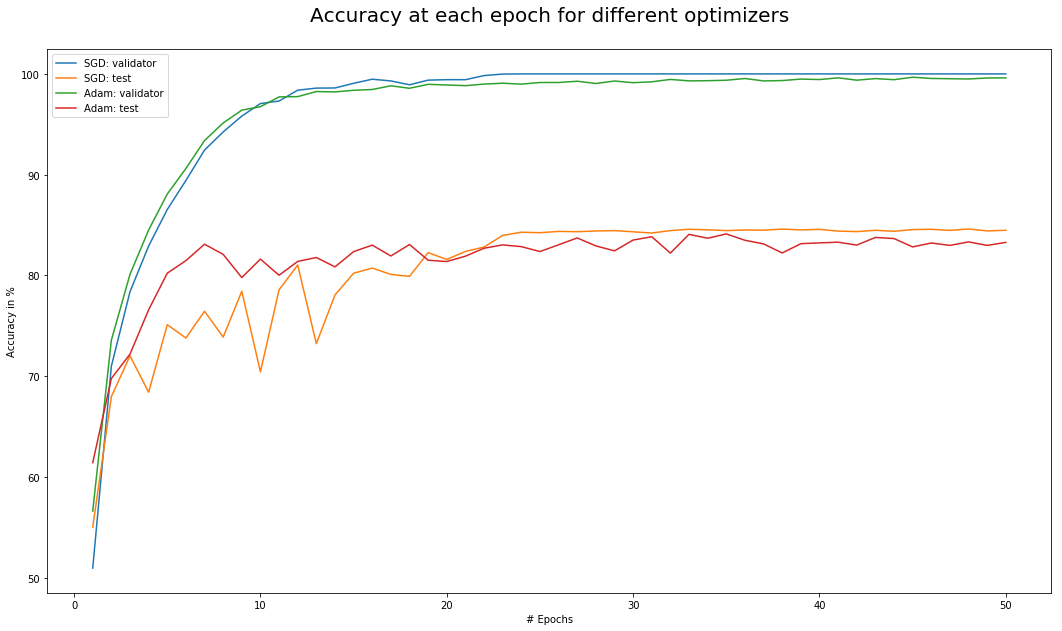

In [97]:
plt.figure(figsize = (18, 10))
plt.title('Accuracy at each epoch for different optimizers\n',fontsize=20)
plt.xlabel('# Epochs')
plt.ylabel('Accuracy in %')
plt.plot(range(1,51), SGDacc[0], antialiased=True, label='SGD: validator')
plt.plot(range(1,51), SGDacc[1], antialiased=True, label='SGD: test')
plt.plot(range(1,51), Adamacc[0], antialiased=True, label='Adam: validator')
plt.plot(range(1,51), Adamacc[1], antialiased=True, label='Adam: test')
plt.legend()

As one can see, the test accuray curves are subjected to greater jitters and generally stay below the validator curves in terms of accuracy.

### Task 3

Now implement decaying the learning rate using the `ReduceLROnPlateau` scheme in your training with $\delta=0.9$ and plot the validation and test accuracy over the course of the training using the `SGD` and `Adam` optimizer. You will need to lookup the PyTorch API to figure out how to use this scheme.

We assume that $\delta$ is the factor by which the learning rate is reduced, thus passing the function parameter `factor` to `ReduceLROnPlateau`:

In [102]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
SGDR_= NNRunner(traindata, testdata, optim.SGD, {'lr' : 0.1}, ReduceLROnPlateau, {'factor' : 0.9})
#import pdb; pdb.set_trace()
SGDacc_ = SGDR_.run(epoch=50)
AdamR_= NNRunner(traindata, testdata, optim.Adam, {}, ReduceLROnPlateau, {'factor' : 0.9})
Adamacc_ = AdamR_.run(epoch=50)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.366150
Train Epoch: 1 [1280/50000 (3%)]	Loss: 2.170182
Train Epoch: 1 [2560/50000 (5%)]	Loss: 1.869052
Train Epoch: 1 [3840/50000 (8%)]	Loss: 1.937208
Train Epoch: 1 [5120/50000 (10%)]	Loss: 1.747066
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.763485
Train Epoch: 1 [7680/50000 (15%)]	Loss: 1.552490
Train Epoch: 1 [8960/50000 (18%)]	Loss: 1.629187
Train Epoch: 1 [10240/50000 (20%)]	Loss: 1.626339
Train Epoch: 1 [11520/50000 (23%)]	Loss: 1.397994
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.396770
Train Epoch: 1 [14080/50000 (28%)]	Loss: 1.597000
Train Epoch: 1 [15360/50000 (31%)]	Loss: 1.388981
Train Epoch: 1 [16640/50000 (33%)]	Loss: 1.431550
Train Epoch: 1 [17920/50000 (36%)]	Loss: 1.337466
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.350715
Train Epoch: 1 [20480/50000 (41%)]	Loss: 1.476626
Train Epoch: 1 [21760/50000 (43%)]	Loss: 1.455299
Train Epoch: 1 [23040/50000 (46%)]	Loss: 1.261828
Train Epoch: 1 [24320/50000 (49%)]	Loss: 1.022884
Train Epoch: 1 

Train Epoch: 4 [48640/50000 (97%)]	Loss: 0.420141
Train Epoch: 4 [31200/50000 (100%)]	Loss: 0.433244

Training set: Average loss: 0.4815, Accuracy: 41543/50000 (83%)

Test set: Average loss: 1.0677, Accuracy: 6756/10000 (68%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 0.406552
Train Epoch: 5 [1280/50000 (3%)]	Loss: 0.309503
Train Epoch: 5 [2560/50000 (5%)]	Loss: 0.357656
Train Epoch: 5 [3840/50000 (8%)]	Loss: 0.493661
Train Epoch: 5 [5120/50000 (10%)]	Loss: 0.318047
Train Epoch: 5 [6400/50000 (13%)]	Loss: 0.373244
Train Epoch: 5 [7680/50000 (15%)]	Loss: 0.402633
Train Epoch: 5 [8960/50000 (18%)]	Loss: 0.301244
Train Epoch: 5 [10240/50000 (20%)]	Loss: 0.382773
Train Epoch: 5 [11520/50000 (23%)]	Loss: 0.491061
Train Epoch: 5 [12800/50000 (26%)]	Loss: 0.206249
Train Epoch: 5 [14080/50000 (28%)]	Loss: 0.372882
Train Epoch: 5 [15360/50000 (31%)]	Loss: 0.251798
Train Epoch: 5 [16640/50000 (33%)]	Loss: 0.499236
Train Epoch: 5 [17920/50000 (36%)]	Loss: 0.369509
Train Epoch: 5 [19200/50000 (38%)]	Los

Train Epoch: 8 [42240/50000 (84%)]	Loss: 0.325461
Train Epoch: 8 [43520/50000 (87%)]	Loss: 0.131632
Train Epoch: 8 [44800/50000 (90%)]	Loss: 0.105628
Train Epoch: 8 [46080/50000 (92%)]	Loss: 0.218503
Train Epoch: 8 [47360/50000 (95%)]	Loss: 0.160839
Train Epoch: 8 [48640/50000 (97%)]	Loss: 0.171972
Train Epoch: 8 [31200/50000 (100%)]	Loss: 0.218792

Training set: Average loss: 0.1599, Accuracy: 47260/50000 (95%)

Test set: Average loss: 0.8228, Accuracy: 7776/10000 (78%)

Train Epoch: 9 [0/50000 (0%)]	Loss: 0.086420
Train Epoch: 9 [1280/50000 (3%)]	Loss: 0.110417
Train Epoch: 9 [2560/50000 (5%)]	Loss: 0.067098
Train Epoch: 9 [3840/50000 (8%)]	Loss: 0.103691
Train Epoch: 9 [5120/50000 (10%)]	Loss: 0.107506
Train Epoch: 9 [6400/50000 (13%)]	Loss: 0.089011
Train Epoch: 9 [7680/50000 (15%)]	Loss: 0.095459
Train Epoch: 9 [8960/50000 (18%)]	Loss: 0.113698
Train Epoch: 9 [10240/50000 (20%)]	Loss: 0.093918
Train Epoch: 9 [11520/50000 (23%)]	Loss: 0.076220
Train Epoch: 9 [12800/50000 (26%)]	Los

Train Epoch: 12 [33280/50000 (66%)]	Loss: 0.068364
Train Epoch: 12 [34560/50000 (69%)]	Loss: 0.027205
Train Epoch: 12 [35840/50000 (72%)]	Loss: 0.066224
Train Epoch: 12 [37120/50000 (74%)]	Loss: 0.024837
Train Epoch: 12 [38400/50000 (77%)]	Loss: 0.075120
Train Epoch: 12 [39680/50000 (79%)]	Loss: 0.061076
Train Epoch: 12 [40960/50000 (82%)]	Loss: 0.025216
Train Epoch: 12 [42240/50000 (84%)]	Loss: 0.042381
Train Epoch: 12 [43520/50000 (87%)]	Loss: 0.029223
Train Epoch: 12 [44800/50000 (90%)]	Loss: 0.077370
Train Epoch: 12 [46080/50000 (92%)]	Loss: 0.073052
Train Epoch: 12 [47360/50000 (95%)]	Loss: 0.133178
Train Epoch: 12 [48640/50000 (97%)]	Loss: 0.098232
Train Epoch: 12 [31200/50000 (100%)]	Loss: 0.201838

Training set: Average loss: 0.0509, Accuracy: 49091/50000 (98%)

Test set: Average loss: 1.4832, Accuracy: 7327/10000 (73%)

Train Epoch: 13 [0/50000 (0%)]	Loss: 0.120153
Train Epoch: 13 [1280/50000 (3%)]	Loss: 0.018264
Train Epoch: 13 [2560/50000 (5%)]	Loss: 0.038586
Train Epoch: 13

Train Epoch: 16 [23040/50000 (46%)]	Loss: 0.004740
Train Epoch: 16 [24320/50000 (49%)]	Loss: 0.011592
Train Epoch: 16 [25600/50000 (51%)]	Loss: 0.029765
Train Epoch: 16 [26880/50000 (54%)]	Loss: 0.016627
Train Epoch: 16 [28160/50000 (56%)]	Loss: 0.019391
Train Epoch: 16 [29440/50000 (59%)]	Loss: 0.041936
Train Epoch: 16 [30720/50000 (61%)]	Loss: 0.071189
Train Epoch: 16 [32000/50000 (64%)]	Loss: 0.046499
Train Epoch: 16 [33280/50000 (66%)]	Loss: 0.120998
Train Epoch: 16 [34560/50000 (69%)]	Loss: 0.005941
Train Epoch: 16 [35840/50000 (72%)]	Loss: 0.020646
Train Epoch: 16 [37120/50000 (74%)]	Loss: 0.004639
Train Epoch: 16 [38400/50000 (77%)]	Loss: 0.023728
Train Epoch: 16 [39680/50000 (79%)]	Loss: 0.013375
Train Epoch: 16 [40960/50000 (82%)]	Loss: 0.023859
Train Epoch: 16 [42240/50000 (84%)]	Loss: 0.005243
Train Epoch: 16 [43520/50000 (87%)]	Loss: 0.037414
Train Epoch: 16 [44800/50000 (90%)]	Loss: 0.018623
Train Epoch: 16 [46080/50000 (92%)]	Loss: 0.035197
Train Epoch: 16 [47360/50000 (9

Train Epoch: 20 [12800/50000 (26%)]	Loss: 0.000984
Train Epoch: 20 [14080/50000 (28%)]	Loss: 0.003890
Train Epoch: 20 [15360/50000 (31%)]	Loss: 0.000743
Train Epoch: 20 [16640/50000 (33%)]	Loss: 0.001342
Train Epoch: 20 [17920/50000 (36%)]	Loss: 0.000848
Train Epoch: 20 [19200/50000 (38%)]	Loss: 0.001607
Train Epoch: 20 [20480/50000 (41%)]	Loss: 0.010480
Train Epoch: 20 [21760/50000 (43%)]	Loss: 0.001488
Train Epoch: 20 [23040/50000 (46%)]	Loss: 0.005111
Train Epoch: 20 [24320/50000 (49%)]	Loss: 0.003926
Train Epoch: 20 [25600/50000 (51%)]	Loss: 0.000319
Train Epoch: 20 [26880/50000 (54%)]	Loss: 0.002425
Train Epoch: 20 [28160/50000 (56%)]	Loss: 0.004229
Train Epoch: 20 [29440/50000 (59%)]	Loss: 0.003569
Train Epoch: 20 [30720/50000 (61%)]	Loss: 0.001065
Train Epoch: 20 [32000/50000 (64%)]	Loss: 0.000474
Train Epoch: 20 [33280/50000 (66%)]	Loss: 0.000507
Train Epoch: 20 [34560/50000 (69%)]	Loss: 0.013748
Train Epoch: 20 [35840/50000 (72%)]	Loss: 0.003159
Train Epoch: 20 [37120/50000 (7

Train Epoch: 24 [2560/50000 (5%)]	Loss: 0.000130
Train Epoch: 24 [3840/50000 (8%)]	Loss: 0.000391
Train Epoch: 24 [5120/50000 (10%)]	Loss: 0.000161
Train Epoch: 24 [6400/50000 (13%)]	Loss: 0.000121
Train Epoch: 24 [7680/50000 (15%)]	Loss: 0.000410
Train Epoch: 24 [8960/50000 (18%)]	Loss: 0.000067
Train Epoch: 24 [10240/50000 (20%)]	Loss: 0.000107
Train Epoch: 24 [11520/50000 (23%)]	Loss: 0.000392
Train Epoch: 24 [12800/50000 (26%)]	Loss: 0.000226
Train Epoch: 24 [14080/50000 (28%)]	Loss: 0.000593
Train Epoch: 24 [15360/50000 (31%)]	Loss: 0.000109
Train Epoch: 24 [16640/50000 (33%)]	Loss: 0.000194
Train Epoch: 24 [17920/50000 (36%)]	Loss: 0.000080
Train Epoch: 24 [19200/50000 (38%)]	Loss: 0.000170
Train Epoch: 24 [20480/50000 (41%)]	Loss: 0.000183
Train Epoch: 24 [21760/50000 (43%)]	Loss: 0.000083
Train Epoch: 24 [23040/50000 (46%)]	Loss: 0.000181
Train Epoch: 24 [24320/50000 (49%)]	Loss: 0.000562
Train Epoch: 24 [25600/50000 (51%)]	Loss: 0.000190
Train Epoch: 24 [26880/50000 (54%)]	Los

Train Epoch: 27 [47360/50000 (95%)]	Loss: 0.000341
Train Epoch: 27 [48640/50000 (97%)]	Loss: 0.000073
Train Epoch: 27 [31200/50000 (100%)]	Loss: 0.000237

Training set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Test set: Average loss: 0.9124, Accuracy: 8402/10000 (84%)

Train Epoch: 28 [0/50000 (0%)]	Loss: 0.000325
Train Epoch: 28 [1280/50000 (3%)]	Loss: 0.000141
Train Epoch: 28 [2560/50000 (5%)]	Loss: 0.000055
Train Epoch: 28 [3840/50000 (8%)]	Loss: 0.000090
Train Epoch: 28 [5120/50000 (10%)]	Loss: 0.000204
Train Epoch: 28 [6400/50000 (13%)]	Loss: 0.000134
Train Epoch: 28 [7680/50000 (15%)]	Loss: 0.000190
Train Epoch: 28 [8960/50000 (18%)]	Loss: 0.000067
Train Epoch: 28 [10240/50000 (20%)]	Loss: 0.000080
Train Epoch: 28 [11520/50000 (23%)]	Loss: 0.000273
Train Epoch: 28 [12800/50000 (26%)]	Loss: 0.000068
Train Epoch: 28 [14080/50000 (28%)]	Loss: 0.000074
Train Epoch: 28 [15360/50000 (31%)]	Loss: 0.000048
Train Epoch: 28 [16640/50000 (33%)]	Loss: 0.000097
Train Epoch: 28 [179

Train Epoch: 31 [37120/50000 (74%)]	Loss: 0.000126
Train Epoch: 31 [38400/50000 (77%)]	Loss: 0.000911
Train Epoch: 31 [39680/50000 (79%)]	Loss: 0.000056
Train Epoch: 31 [40960/50000 (82%)]	Loss: 0.000054
Train Epoch: 31 [42240/50000 (84%)]	Loss: 0.000059
Train Epoch: 31 [43520/50000 (87%)]	Loss: 0.000066
Train Epoch: 31 [44800/50000 (90%)]	Loss: 0.000038
Train Epoch: 31 [46080/50000 (92%)]	Loss: 0.000051
Train Epoch: 31 [47360/50000 (95%)]	Loss: 0.000093
Train Epoch: 31 [48640/50000 (97%)]	Loss: 0.000125
Train Epoch: 31 [31200/50000 (100%)]	Loss: 0.000029

Training set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Test set: Average loss: 0.9227, Accuracy: 8408/10000 (84%)

Train Epoch: 32 [0/50000 (0%)]	Loss: 0.000088
Train Epoch: 32 [1280/50000 (3%)]	Loss: 0.000122
Train Epoch: 32 [2560/50000 (5%)]	Loss: 0.000070
Train Epoch: 32 [3840/50000 (8%)]	Loss: 0.000032
Train Epoch: 32 [5120/50000 (10%)]	Loss: 0.000055
Train Epoch: 32 [6400/50000 (13%)]	Loss: 0.000034
Train Epoch: 32 [7

Train Epoch: 35 [26880/50000 (54%)]	Loss: 0.000068
Train Epoch: 35 [28160/50000 (56%)]	Loss: 0.000054
Train Epoch: 35 [29440/50000 (59%)]	Loss: 0.000086
Train Epoch: 35 [30720/50000 (61%)]	Loss: 0.000056
Train Epoch: 35 [32000/50000 (64%)]	Loss: 0.000027
Train Epoch: 35 [33280/50000 (66%)]	Loss: 0.000103
Train Epoch: 35 [34560/50000 (69%)]	Loss: 0.000086
Train Epoch: 35 [35840/50000 (72%)]	Loss: 0.000045
Train Epoch: 35 [37120/50000 (74%)]	Loss: 0.000080
Train Epoch: 35 [38400/50000 (77%)]	Loss: 0.000225
Train Epoch: 35 [39680/50000 (79%)]	Loss: 0.000036
Train Epoch: 35 [40960/50000 (82%)]	Loss: 0.000035
Train Epoch: 35 [42240/50000 (84%)]	Loss: 0.000033
Train Epoch: 35 [43520/50000 (87%)]	Loss: 0.000105
Train Epoch: 35 [44800/50000 (90%)]	Loss: 0.000048
Train Epoch: 35 [46080/50000 (92%)]	Loss: 0.000073
Train Epoch: 35 [47360/50000 (95%)]	Loss: 0.000134
Train Epoch: 35 [48640/50000 (97%)]	Loss: 0.000048
Train Epoch: 35 [31200/50000 (100%)]	Loss: 0.000057

Training set: Average loss: 0

Train Epoch: 39 [16640/50000 (33%)]	Loss: 0.000079
Train Epoch: 39 [17920/50000 (36%)]	Loss: 0.000012
Train Epoch: 39 [19200/50000 (38%)]	Loss: 0.000042
Train Epoch: 39 [20480/50000 (41%)]	Loss: 0.000020
Train Epoch: 39 [21760/50000 (43%)]	Loss: 0.000018
Train Epoch: 39 [23040/50000 (46%)]	Loss: 0.000025
Train Epoch: 39 [24320/50000 (49%)]	Loss: 0.000050
Train Epoch: 39 [25600/50000 (51%)]	Loss: 0.000034
Train Epoch: 39 [26880/50000 (54%)]	Loss: 0.000045
Train Epoch: 39 [28160/50000 (56%)]	Loss: 0.000109
Train Epoch: 39 [29440/50000 (59%)]	Loss: 0.000037
Train Epoch: 39 [30720/50000 (61%)]	Loss: 0.000074
Train Epoch: 39 [32000/50000 (64%)]	Loss: 0.000058
Train Epoch: 39 [33280/50000 (66%)]	Loss: 0.000033
Train Epoch: 39 [34560/50000 (69%)]	Loss: 0.000608
Train Epoch: 39 [35840/50000 (72%)]	Loss: 0.000020
Train Epoch: 39 [37120/50000 (74%)]	Loss: 0.000047
Train Epoch: 39 [38400/50000 (77%)]	Loss: 0.000050
Train Epoch: 39 [39680/50000 (79%)]	Loss: 0.000118
Train Epoch: 39 [40960/50000 (8

Train Epoch: 43 [6400/50000 (13%)]	Loss: 0.000079
Train Epoch: 43 [7680/50000 (15%)]	Loss: 0.000009
Train Epoch: 43 [8960/50000 (18%)]	Loss: 0.000021
Train Epoch: 43 [10240/50000 (20%)]	Loss: 0.000029
Train Epoch: 43 [11520/50000 (23%)]	Loss: 0.000058
Train Epoch: 43 [12800/50000 (26%)]	Loss: 0.000035
Train Epoch: 43 [14080/50000 (28%)]	Loss: 0.000039
Train Epoch: 43 [15360/50000 (31%)]	Loss: 0.000278
Train Epoch: 43 [16640/50000 (33%)]	Loss: 0.000018
Train Epoch: 43 [17920/50000 (36%)]	Loss: 0.000060
Train Epoch: 43 [19200/50000 (38%)]	Loss: 0.000111
Train Epoch: 43 [20480/50000 (41%)]	Loss: 0.000017
Train Epoch: 43 [21760/50000 (43%)]	Loss: 0.000018
Train Epoch: 43 [23040/50000 (46%)]	Loss: 0.000036
Train Epoch: 43 [24320/50000 (49%)]	Loss: 0.000064
Train Epoch: 43 [25600/50000 (51%)]	Loss: 0.000059
Train Epoch: 43 [26880/50000 (54%)]	Loss: 0.000022
Train Epoch: 43 [28160/50000 (56%)]	Loss: 0.000058
Train Epoch: 43 [29440/50000 (59%)]	Loss: 0.000025
Train Epoch: 43 [30720/50000 (61%)


Test set: Average loss: 0.9347, Accuracy: 8431/10000 (84%)

Train Epoch: 47 [0/50000 (0%)]	Loss: 0.000080
Train Epoch: 47 [1280/50000 (3%)]	Loss: 0.000014
Train Epoch: 47 [2560/50000 (5%)]	Loss: 0.000029
Train Epoch: 47 [3840/50000 (8%)]	Loss: 0.000044
Train Epoch: 47 [5120/50000 (10%)]	Loss: 0.000047
Train Epoch: 47 [6400/50000 (13%)]	Loss: 0.000051
Train Epoch: 47 [7680/50000 (15%)]	Loss: 0.000027
Train Epoch: 47 [8960/50000 (18%)]	Loss: 0.000033
Train Epoch: 47 [10240/50000 (20%)]	Loss: 0.000039
Train Epoch: 47 [11520/50000 (23%)]	Loss: 0.000016
Train Epoch: 47 [12800/50000 (26%)]	Loss: 0.000033
Train Epoch: 47 [14080/50000 (28%)]	Loss: 0.000040
Train Epoch: 47 [15360/50000 (31%)]	Loss: 0.000018
Train Epoch: 47 [16640/50000 (33%)]	Loss: 0.000020
Train Epoch: 47 [17920/50000 (36%)]	Loss: 0.000022
Train Epoch: 47 [19200/50000 (38%)]	Loss: 0.000028
Train Epoch: 47 [20480/50000 (41%)]	Loss: 0.000014
Train Epoch: 47 [21760/50000 (43%)]	Loss: 0.000024
Train Epoch: 47 [23040/50000 (46%)]	

Train Epoch: 50 [43520/50000 (87%)]	Loss: 0.000019
Train Epoch: 50 [44800/50000 (90%)]	Loss: 0.000018
Train Epoch: 50 [46080/50000 (92%)]	Loss: 0.000008
Train Epoch: 50 [47360/50000 (95%)]	Loss: 0.000029
Train Epoch: 50 [48640/50000 (97%)]	Loss: 0.000056
Train Epoch: 50 [31200/50000 (100%)]	Loss: 0.000046

Training set: Average loss: 0.0000, Accuracy: 50000/50000 (100%)

Test set: Average loss: 0.9422, Accuracy: 8424/10000 (84%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.298037
Train Epoch: 1 [1280/50000 (3%)]	Loss: 1.885125
Train Epoch: 1 [2560/50000 (5%)]	Loss: 1.683278
Train Epoch: 1 [3840/50000 (8%)]	Loss: 1.673142
Train Epoch: 1 [5120/50000 (10%)]	Loss: 1.570911
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.354829
Train Epoch: 1 [7680/50000 (15%)]	Loss: 1.466775
Train Epoch: 1 [8960/50000 (18%)]	Loss: 1.514176
Train Epoch: 1 [10240/50000 (20%)]	Loss: 1.505770
Train Epoch: 1 [11520/50000 (23%)]	Loss: 1.292893
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.580055
Train Epoch: 1 [14080/50000 (28

Train Epoch: 4 [37120/50000 (74%)]	Loss: 0.427388
Train Epoch: 4 [38400/50000 (77%)]	Loss: 0.392905
Train Epoch: 4 [39680/50000 (79%)]	Loss: 0.429608
Train Epoch: 4 [40960/50000 (82%)]	Loss: 0.612520
Train Epoch: 4 [42240/50000 (84%)]	Loss: 0.509414
Train Epoch: 4 [43520/50000 (87%)]	Loss: 0.332872
Train Epoch: 4 [44800/50000 (90%)]	Loss: 0.510854
Train Epoch: 4 [46080/50000 (92%)]	Loss: 0.376889
Train Epoch: 4 [47360/50000 (95%)]	Loss: 0.502974
Train Epoch: 4 [48640/50000 (97%)]	Loss: 0.480292
Train Epoch: 4 [31200/50000 (100%)]	Loss: 0.565902

Training set: Average loss: 0.4677, Accuracy: 41822/50000 (84%)

Test set: Average loss: 0.7069, Accuracy: 7638/10000 (76%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 0.332280
Train Epoch: 5 [1280/50000 (3%)]	Loss: 0.379947
Train Epoch: 5 [2560/50000 (5%)]	Loss: 0.323345
Train Epoch: 5 [3840/50000 (8%)]	Loss: 0.320219
Train Epoch: 5 [5120/50000 (10%)]	Loss: 0.279051
Train Epoch: 5 [6400/50000 (13%)]	Loss: 0.356224
Train Epoch: 5 [7680/50000 (15%)]	Lo

Train Epoch: 8 [30720/50000 (61%)]	Loss: 0.220727
Train Epoch: 8 [32000/50000 (64%)]	Loss: 0.260593
Train Epoch: 8 [33280/50000 (66%)]	Loss: 0.132631
Train Epoch: 8 [34560/50000 (69%)]	Loss: 0.115745
Train Epoch: 8 [35840/50000 (72%)]	Loss: 0.161289
Train Epoch: 8 [37120/50000 (74%)]	Loss: 0.176597
Train Epoch: 8 [38400/50000 (77%)]	Loss: 0.182532
Train Epoch: 8 [39680/50000 (79%)]	Loss: 0.172375
Train Epoch: 8 [40960/50000 (82%)]	Loss: 0.129184
Train Epoch: 8 [42240/50000 (84%)]	Loss: 0.210891
Train Epoch: 8 [43520/50000 (87%)]	Loss: 0.151471
Train Epoch: 8 [44800/50000 (90%)]	Loss: 0.202433
Train Epoch: 8 [46080/50000 (92%)]	Loss: 0.155461
Train Epoch: 8 [47360/50000 (95%)]	Loss: 0.247087
Train Epoch: 8 [48640/50000 (97%)]	Loss: 0.172506
Train Epoch: 8 [31200/50000 (100%)]	Loss: 0.179283

Training set: Average loss: 0.1502, Accuracy: 47383/50000 (95%)

Test set: Average loss: 0.7657, Accuracy: 7997/10000 (80%)

Train Epoch: 9 [0/50000 (0%)]	Loss: 0.089748
Train Epoch: 9 [1280/50000 (

Train Epoch: 12 [21760/50000 (43%)]	Loss: 0.085367
Train Epoch: 12 [23040/50000 (46%)]	Loss: 0.087491
Train Epoch: 12 [24320/50000 (49%)]	Loss: 0.035518
Train Epoch: 12 [25600/50000 (51%)]	Loss: 0.035397
Train Epoch: 12 [26880/50000 (54%)]	Loss: 0.048438
Train Epoch: 12 [28160/50000 (56%)]	Loss: 0.107246
Train Epoch: 12 [29440/50000 (59%)]	Loss: 0.102075
Train Epoch: 12 [30720/50000 (61%)]	Loss: 0.085951
Train Epoch: 12 [32000/50000 (64%)]	Loss: 0.174304
Train Epoch: 12 [33280/50000 (66%)]	Loss: 0.048053
Train Epoch: 12 [34560/50000 (69%)]	Loss: 0.109424
Train Epoch: 12 [35840/50000 (72%)]	Loss: 0.108347
Train Epoch: 12 [37120/50000 (74%)]	Loss: 0.087335
Train Epoch: 12 [38400/50000 (77%)]	Loss: 0.095378
Train Epoch: 12 [39680/50000 (79%)]	Loss: 0.048331
Train Epoch: 12 [40960/50000 (82%)]	Loss: 0.034137
Train Epoch: 12 [42240/50000 (84%)]	Loss: 0.046813
Train Epoch: 12 [43520/50000 (87%)]	Loss: 0.059234
Train Epoch: 12 [44800/50000 (90%)]	Loss: 0.061890
Train Epoch: 12 [46080/50000 (9

Train Epoch: 16 [11520/50000 (23%)]	Loss: 0.048220
Train Epoch: 16 [12800/50000 (26%)]	Loss: 0.081675
Train Epoch: 16 [14080/50000 (28%)]	Loss: 0.019114
Train Epoch: 16 [15360/50000 (31%)]	Loss: 0.022608
Train Epoch: 16 [16640/50000 (33%)]	Loss: 0.020235
Train Epoch: 16 [17920/50000 (36%)]	Loss: 0.032988
Train Epoch: 16 [19200/50000 (38%)]	Loss: 0.042798
Train Epoch: 16 [20480/50000 (41%)]	Loss: 0.033283
Train Epoch: 16 [21760/50000 (43%)]	Loss: 0.046278
Train Epoch: 16 [23040/50000 (46%)]	Loss: 0.035290
Train Epoch: 16 [24320/50000 (49%)]	Loss: 0.043498
Train Epoch: 16 [25600/50000 (51%)]	Loss: 0.025274
Train Epoch: 16 [26880/50000 (54%)]	Loss: 0.017229
Train Epoch: 16 [28160/50000 (56%)]	Loss: 0.062982
Train Epoch: 16 [29440/50000 (59%)]	Loss: 0.035454
Train Epoch: 16 [30720/50000 (61%)]	Loss: 0.125076
Train Epoch: 16 [32000/50000 (64%)]	Loss: 0.077106
Train Epoch: 16 [33280/50000 (66%)]	Loss: 0.022427
Train Epoch: 16 [34560/50000 (69%)]	Loss: 0.099668
Train Epoch: 16 [35840/50000 (7

Train Epoch: 20 [1280/50000 (3%)]	Loss: 0.073657
Train Epoch: 20 [2560/50000 (5%)]	Loss: 0.018402
Train Epoch: 20 [3840/50000 (8%)]	Loss: 0.030397
Train Epoch: 20 [5120/50000 (10%)]	Loss: 0.014810
Train Epoch: 20 [6400/50000 (13%)]	Loss: 0.021457
Train Epoch: 20 [7680/50000 (15%)]	Loss: 0.023739
Train Epoch: 20 [8960/50000 (18%)]	Loss: 0.029927
Train Epoch: 20 [10240/50000 (20%)]	Loss: 0.064494
Train Epoch: 20 [11520/50000 (23%)]	Loss: 0.008721
Train Epoch: 20 [12800/50000 (26%)]	Loss: 0.068788
Train Epoch: 20 [14080/50000 (28%)]	Loss: 0.024133
Train Epoch: 20 [15360/50000 (31%)]	Loss: 0.044253
Train Epoch: 20 [16640/50000 (33%)]	Loss: 0.029536
Train Epoch: 20 [17920/50000 (36%)]	Loss: 0.018842
Train Epoch: 20 [19200/50000 (38%)]	Loss: 0.055373
Train Epoch: 20 [20480/50000 (41%)]	Loss: 0.055106
Train Epoch: 20 [21760/50000 (43%)]	Loss: 0.026959
Train Epoch: 20 [23040/50000 (46%)]	Loss: 0.040180
Train Epoch: 20 [24320/50000 (49%)]	Loss: 0.033568
Train Epoch: 20 [25600/50000 (51%)]	Loss:

Train Epoch: 23 [46080/50000 (92%)]	Loss: 0.003879
Train Epoch: 23 [47360/50000 (95%)]	Loss: 0.013119
Train Epoch: 23 [48640/50000 (97%)]	Loss: 0.058579
Train Epoch: 23 [31200/50000 (100%)]	Loss: 0.011288

Training set: Average loss: 0.0262, Accuracy: 49566/50000 (99%)

Test set: Average loss: 0.8939, Accuracy: 8328/10000 (83%)

Train Epoch: 24 [0/50000 (0%)]	Loss: 0.008446
Train Epoch: 24 [1280/50000 (3%)]	Loss: 0.099851
Train Epoch: 24 [2560/50000 (5%)]	Loss: 0.007645
Train Epoch: 24 [3840/50000 (8%)]	Loss: 0.003907
Train Epoch: 24 [5120/50000 (10%)]	Loss: 0.003238
Train Epoch: 24 [6400/50000 (13%)]	Loss: 0.003536
Train Epoch: 24 [7680/50000 (15%)]	Loss: 0.035383
Train Epoch: 24 [8960/50000 (18%)]	Loss: 0.044994
Train Epoch: 24 [10240/50000 (20%)]	Loss: 0.011898
Train Epoch: 24 [11520/50000 (23%)]	Loss: 0.072153
Train Epoch: 24 [12800/50000 (26%)]	Loss: 0.033420
Train Epoch: 24 [14080/50000 (28%)]	Loss: 0.011175
Train Epoch: 24 [15360/50000 (31%)]	Loss: 0.020454
Train Epoch: 24 [1664

Train Epoch: 27 [35840/50000 (72%)]	Loss: 0.015831
Train Epoch: 27 [37120/50000 (74%)]	Loss: 0.031910
Train Epoch: 27 [38400/50000 (77%)]	Loss: 0.033887
Train Epoch: 27 [39680/50000 (79%)]	Loss: 0.026641
Train Epoch: 27 [40960/50000 (82%)]	Loss: 0.005483
Train Epoch: 27 [42240/50000 (84%)]	Loss: 0.031909
Train Epoch: 27 [43520/50000 (87%)]	Loss: 0.008483
Train Epoch: 27 [44800/50000 (90%)]	Loss: 0.065556
Train Epoch: 27 [46080/50000 (92%)]	Loss: 0.083743
Train Epoch: 27 [47360/50000 (95%)]	Loss: 0.045790
Train Epoch: 27 [48640/50000 (97%)]	Loss: 0.036912
Train Epoch: 27 [31200/50000 (100%)]	Loss: 0.033875

Training set: Average loss: 0.0282, Accuracy: 49513/50000 (99%)

Test set: Average loss: 0.8620, Accuracy: 8288/10000 (83%)

Train Epoch: 28 [0/50000 (0%)]	Loss: 0.011989
Train Epoch: 28 [1280/50000 (3%)]	Loss: 0.010820
Train Epoch: 28 [2560/50000 (5%)]	Loss: 0.026767
Train Epoch: 28 [3840/50000 (8%)]	Loss: 0.013234
Train Epoch: 28 [5120/50000 (10%)]	Loss: 0.011355
Train Epoch: 28 [6

Train Epoch: 31 [25600/50000 (51%)]	Loss: 0.016674
Train Epoch: 31 [26880/50000 (54%)]	Loss: 0.055254
Train Epoch: 31 [28160/50000 (56%)]	Loss: 0.023009
Train Epoch: 31 [29440/50000 (59%)]	Loss: 0.022852
Train Epoch: 31 [30720/50000 (61%)]	Loss: 0.001436
Train Epoch: 31 [32000/50000 (64%)]	Loss: 0.002327
Train Epoch: 31 [33280/50000 (66%)]	Loss: 0.020287
Train Epoch: 31 [34560/50000 (69%)]	Loss: 0.004997
Train Epoch: 31 [35840/50000 (72%)]	Loss: 0.013700
Train Epoch: 31 [37120/50000 (74%)]	Loss: 0.017676
Train Epoch: 31 [38400/50000 (77%)]	Loss: 0.055691
Train Epoch: 31 [39680/50000 (79%)]	Loss: 0.067541
Train Epoch: 31 [40960/50000 (82%)]	Loss: 0.005158
Train Epoch: 31 [42240/50000 (84%)]	Loss: 0.042911
Train Epoch: 31 [43520/50000 (87%)]	Loss: 0.002915
Train Epoch: 31 [44800/50000 (90%)]	Loss: 0.057500
Train Epoch: 31 [46080/50000 (92%)]	Loss: 0.039229
Train Epoch: 31 [47360/50000 (95%)]	Loss: 0.004413
Train Epoch: 31 [48640/50000 (97%)]	Loss: 0.014930
Train Epoch: 31 [31200/50000 (1

Train Epoch: 35 [15360/50000 (31%)]	Loss: 0.036145
Train Epoch: 35 [16640/50000 (33%)]	Loss: 0.031983
Train Epoch: 35 [17920/50000 (36%)]	Loss: 0.038165
Train Epoch: 35 [19200/50000 (38%)]	Loss: 0.008936
Train Epoch: 35 [20480/50000 (41%)]	Loss: 0.021131
Train Epoch: 35 [21760/50000 (43%)]	Loss: 0.000615
Train Epoch: 35 [23040/50000 (46%)]	Loss: 0.001859
Train Epoch: 35 [24320/50000 (49%)]	Loss: 0.005555
Train Epoch: 35 [25600/50000 (51%)]	Loss: 0.023033
Train Epoch: 35 [26880/50000 (54%)]	Loss: 0.016091
Train Epoch: 35 [28160/50000 (56%)]	Loss: 0.003012
Train Epoch: 35 [29440/50000 (59%)]	Loss: 0.006420
Train Epoch: 35 [30720/50000 (61%)]	Loss: 0.001632
Train Epoch: 35 [32000/50000 (64%)]	Loss: 0.009876
Train Epoch: 35 [33280/50000 (66%)]	Loss: 0.004252
Train Epoch: 35 [34560/50000 (69%)]	Loss: 0.005638
Train Epoch: 35 [35840/50000 (72%)]	Loss: 0.010309
Train Epoch: 35 [37120/50000 (74%)]	Loss: 0.007483
Train Epoch: 35 [38400/50000 (77%)]	Loss: 0.014451
Train Epoch: 35 [39680/50000 (7

Train Epoch: 39 [5120/50000 (10%)]	Loss: 0.015925
Train Epoch: 39 [6400/50000 (13%)]	Loss: 0.022666
Train Epoch: 39 [7680/50000 (15%)]	Loss: 0.014738
Train Epoch: 39 [8960/50000 (18%)]	Loss: 0.004436
Train Epoch: 39 [10240/50000 (20%)]	Loss: 0.008061
Train Epoch: 39 [11520/50000 (23%)]	Loss: 0.009657
Train Epoch: 39 [12800/50000 (26%)]	Loss: 0.029800
Train Epoch: 39 [14080/50000 (28%)]	Loss: 0.027170
Train Epoch: 39 [15360/50000 (31%)]	Loss: 0.001495
Train Epoch: 39 [16640/50000 (33%)]	Loss: 0.010631
Train Epoch: 39 [17920/50000 (36%)]	Loss: 0.001524
Train Epoch: 39 [19200/50000 (38%)]	Loss: 0.003787
Train Epoch: 39 [20480/50000 (41%)]	Loss: 0.001350
Train Epoch: 39 [21760/50000 (43%)]	Loss: 0.009707
Train Epoch: 39 [23040/50000 (46%)]	Loss: 0.002117
Train Epoch: 39 [24320/50000 (49%)]	Loss: 0.001707
Train Epoch: 39 [25600/50000 (51%)]	Loss: 0.003248
Train Epoch: 39 [26880/50000 (54%)]	Loss: 0.004674
Train Epoch: 39 [28160/50000 (56%)]	Loss: 0.003721
Train Epoch: 39 [29440/50000 (59%)]

Train Epoch: 42 [31200/50000 (100%)]	Loss: 0.001109

Training set: Average loss: 0.0158, Accuracy: 49749/50000 (99%)

Test set: Average loss: 0.9448, Accuracy: 8330/10000 (83%)

Train Epoch: 43 [0/50000 (0%)]	Loss: 0.020695
Train Epoch: 43 [1280/50000 (3%)]	Loss: 0.004685
Train Epoch: 43 [2560/50000 (5%)]	Loss: 0.002098
Train Epoch: 43 [3840/50000 (8%)]	Loss: 0.001018
Train Epoch: 43 [5120/50000 (10%)]	Loss: 0.003216
Train Epoch: 43 [6400/50000 (13%)]	Loss: 0.002885
Train Epoch: 43 [7680/50000 (15%)]	Loss: 0.002386
Train Epoch: 43 [8960/50000 (18%)]	Loss: 0.004456
Train Epoch: 43 [10240/50000 (20%)]	Loss: 0.004368
Train Epoch: 43 [11520/50000 (23%)]	Loss: 0.004733
Train Epoch: 43 [12800/50000 (26%)]	Loss: 0.000540
Train Epoch: 43 [14080/50000 (28%)]	Loss: 0.009811
Train Epoch: 43 [15360/50000 (31%)]	Loss: 0.033069
Train Epoch: 43 [16640/50000 (33%)]	Loss: 0.022308
Train Epoch: 43 [17920/50000 (36%)]	Loss: 0.001710
Train Epoch: 43 [19200/50000 (38%)]	Loss: 0.003238
Train Epoch: 43 [2048

Train Epoch: 46 [39680/50000 (79%)]	Loss: 0.050280
Train Epoch: 46 [40960/50000 (82%)]	Loss: 0.005754
Train Epoch: 46 [42240/50000 (84%)]	Loss: 0.004054
Train Epoch: 46 [43520/50000 (87%)]	Loss: 0.039259
Train Epoch: 46 [44800/50000 (90%)]	Loss: 0.017588
Train Epoch: 46 [46080/50000 (92%)]	Loss: 0.002260
Train Epoch: 46 [47360/50000 (95%)]	Loss: 0.009213
Train Epoch: 46 [48640/50000 (97%)]	Loss: 0.012829
Train Epoch: 46 [31200/50000 (100%)]	Loss: 0.003460

Training set: Average loss: 0.0133, Accuracy: 49783/50000 (100%)

Test set: Average loss: 1.0465, Accuracy: 8286/10000 (83%)

Train Epoch: 47 [0/50000 (0%)]	Loss: 0.001945
Train Epoch: 47 [1280/50000 (3%)]	Loss: 0.001318
Train Epoch: 47 [2560/50000 (5%)]	Loss: 0.096570
Train Epoch: 47 [3840/50000 (8%)]	Loss: 0.011194
Train Epoch: 47 [5120/50000 (10%)]	Loss: 0.006016
Train Epoch: 47 [6400/50000 (13%)]	Loss: 0.008636
Train Epoch: 47 [7680/50000 (15%)]	Loss: 0.008483
Train Epoch: 47 [8960/50000 (18%)]	Loss: 0.000437
Train Epoch: 47 [102

Train Epoch: 50 [29440/50000 (59%)]	Loss: 0.013580
Train Epoch: 50 [30720/50000 (61%)]	Loss: 0.006500
Train Epoch: 50 [32000/50000 (64%)]	Loss: 0.001507
Train Epoch: 50 [33280/50000 (66%)]	Loss: 0.000157
Train Epoch: 50 [34560/50000 (69%)]	Loss: 0.004746
Train Epoch: 50 [35840/50000 (72%)]	Loss: 0.080319
Train Epoch: 50 [37120/50000 (74%)]	Loss: 0.031093
Train Epoch: 50 [38400/50000 (77%)]	Loss: 0.021105
Train Epoch: 50 [39680/50000 (79%)]	Loss: 0.004784
Train Epoch: 50 [40960/50000 (82%)]	Loss: 0.004460
Train Epoch: 50 [42240/50000 (84%)]	Loss: 0.006495
Train Epoch: 50 [43520/50000 (87%)]	Loss: 0.002401
Train Epoch: 50 [44800/50000 (90%)]	Loss: 0.004557
Train Epoch: 50 [46080/50000 (92%)]	Loss: 0.005274
Train Epoch: 50 [47360/50000 (95%)]	Loss: 0.001175
Train Epoch: 50 [48640/50000 (97%)]	Loss: 0.002461
Train Epoch: 50 [31200/50000 (100%)]	Loss: 0.029690

Training set: Average loss: 0.0117, Accuracy: 49813/50000 (100%)

Test set: Average loss: 0.8949, Accuracy: 8439/10000 (84%)



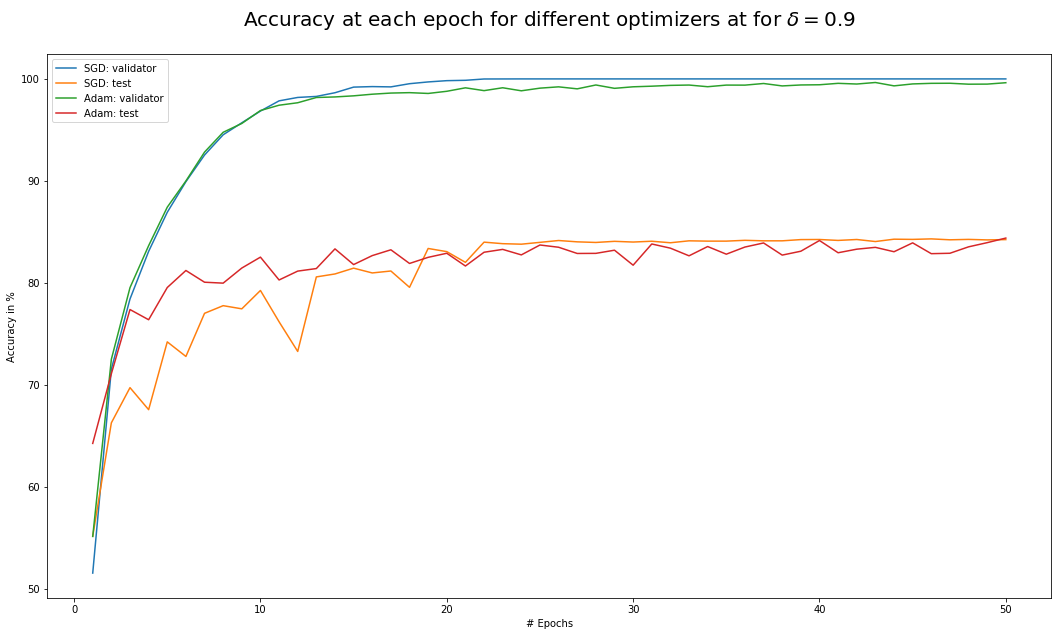

In [103]:
plt.figure(figsize = (18, 10))
plt.title('Accuracy at each epoch for different optimizers at for $\delta=0.9$\n',fontsize=20)
plt.xlabel('# Epochs')
plt.ylabel('Accuracy in %')
plt.plot(range(1,51), SGDacc_[0], antialiased=True, label='SGD: validator')
plt.plot(range(1,51), SGDacc_[1], antialiased=True, label='SGD: test')
plt.plot(range(1,51), Adamacc_[0], antialiased=True, label='Adam: validator')
plt.plot(range(1,51), Adamacc_[1], antialiased=True, label='Adam: test')
plt.legend()

### Task 4

Finally we want to tune the initial step size or  learning rate for the `SGD` and `Adam` for the setup we have till now. 

One strategy is to distribute different learning rates between your fellow classmates and then communicate the best result and refine the learning rate this way till you collectively find the best parameter. This will require some coordination and communication which is what I actually want you do to. Some of your classmates will be confused or stuck, help them! Perhaps you will see some neat helper or good code abstraction, learn from it and apply it to your own code.

Finally, plot the validation accuracy and test accuracy over the course of training for the best learning rate you found for both `SGD` and `Adam`.

In [99]:
SGDR__= NNRunner(traindata, testdata, optim.SGD, {'lr' : 5e-2}, ReduceLROnPlateau, {'factor' : 0.9})
#import pdb; pdb.set_trace()
SGDacc__ = SGDR__.run(epoch=50)
AdamR__= NNRunner(traindata, testdata, optim.Adam, {'lr' : 5e-2}, ReduceLROnPlateau, {'factor' : 0.9})
Adamacc__ = AdamR__.run(epoch=50)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.381063
Train Epoch: 1 [1280/50000 (3%)]	Loss: 1.848202
Train Epoch: 1 [2560/50000 (5%)]	Loss: 1.786523
Train Epoch: 1 [3840/50000 (8%)]	Loss: 1.764349
Train Epoch: 1 [5120/50000 (10%)]	Loss: 1.601551
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.704854
Train Epoch: 1 [7680/50000 (15%)]	Loss: 1.499831
Train Epoch: 1 [8960/50000 (18%)]	Loss: 1.360231
Train Epoch: 1 [10240/50000 (20%)]	Loss: 1.401701
Train Epoch: 1 [11520/50000 (23%)]	Loss: 1.368079
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.613099
Train Epoch: 1 [14080/50000 (28%)]	Loss: 1.452131
Train Epoch: 1 [15360/50000 (31%)]	Loss: 1.400700
Train Epoch: 1 [16640/50000 (33%)]	Loss: 1.332866
Train Epoch: 1 [17920/50000 (36%)]	Loss: 1.307065
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.382727
Train Epoch: 1 [20480/50000 (41%)]	Loss: 1.254368
Train Epoch: 1 [21760/50000 (43%)]	Loss: 1.131466
Train Epoch: 1 [23040/50000 (46%)]	Loss: 1.074272
Train Epoch: 1 [24320/50000 (49%)]	Loss: 1.090775
Train Epoch: 1 

Train Epoch: 4 [48640/50000 (97%)]	Loss: 0.417761
Train Epoch: 4 [31200/50000 (100%)]	Loss: 0.543127

Training set: Average loss: 0.4522, Accuracy: 42143/50000 (84%)

Test set: Average loss: 0.8815, Accuracy: 7160/10000 (72%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 0.419148
Train Epoch: 5 [1280/50000 (3%)]	Loss: 0.336949
Train Epoch: 5 [2560/50000 (5%)]	Loss: 0.252848
Train Epoch: 5 [3840/50000 (8%)]	Loss: 0.208778
Train Epoch: 5 [5120/50000 (10%)]	Loss: 0.211920
Train Epoch: 5 [6400/50000 (13%)]	Loss: 0.400111
Train Epoch: 5 [7680/50000 (15%)]	Loss: 0.456386
Train Epoch: 5 [8960/50000 (18%)]	Loss: 0.292209
Train Epoch: 5 [10240/50000 (20%)]	Loss: 0.381397
Train Epoch: 5 [11520/50000 (23%)]	Loss: 0.403736
Train Epoch: 5 [12800/50000 (26%)]	Loss: 0.423585
Train Epoch: 5 [14080/50000 (28%)]	Loss: 0.461509
Train Epoch: 5 [15360/50000 (31%)]	Loss: 0.433087
Train Epoch: 5 [16640/50000 (33%)]	Loss: 0.289704
Train Epoch: 5 [17920/50000 (36%)]	Loss: 0.405798
Train Epoch: 5 [19200/50000 (38%)]	Los

Train Epoch: 8 [42240/50000 (84%)]	Loss: 0.184785
Train Epoch: 8 [43520/50000 (87%)]	Loss: 0.157700
Train Epoch: 8 [44800/50000 (90%)]	Loss: 0.209346
Train Epoch: 8 [46080/50000 (92%)]	Loss: 0.132314
Train Epoch: 8 [47360/50000 (95%)]	Loss: 0.188539
Train Epoch: 8 [48640/50000 (97%)]	Loss: 0.164827
Train Epoch: 8 [31200/50000 (100%)]	Loss: 0.099392

Training set: Average loss: 0.1257, Accuracy: 47833/50000 (96%)

Test set: Average loss: 0.8324, Accuracy: 7827/10000 (78%)

Train Epoch: 9 [0/50000 (0%)]	Loss: 0.064721
Train Epoch: 9 [1280/50000 (3%)]	Loss: 0.094089
Train Epoch: 9 [2560/50000 (5%)]	Loss: 0.045764
Train Epoch: 9 [3840/50000 (8%)]	Loss: 0.065761
Train Epoch: 9 [5120/50000 (10%)]	Loss: 0.072387
Train Epoch: 9 [6400/50000 (13%)]	Loss: 0.035598
Train Epoch: 9 [7680/50000 (15%)]	Loss: 0.124442
Train Epoch: 9 [8960/50000 (18%)]	Loss: 0.066728
Train Epoch: 9 [10240/50000 (20%)]	Loss: 0.078220
Train Epoch: 9 [11520/50000 (23%)]	Loss: 0.073025
Train Epoch: 9 [12800/50000 (26%)]	Los

Train Epoch: 12 [33280/50000 (66%)]	Loss: 0.102323
Train Epoch: 12 [34560/50000 (69%)]	Loss: 0.044299
Train Epoch: 12 [35840/50000 (72%)]	Loss: 0.029648
Train Epoch: 12 [37120/50000 (74%)]	Loss: 0.036415
Train Epoch: 12 [38400/50000 (77%)]	Loss: 0.025707
Train Epoch: 12 [39680/50000 (79%)]	Loss: 0.029076
Train Epoch: 12 [40960/50000 (82%)]	Loss: 0.107543
Train Epoch: 12 [42240/50000 (84%)]	Loss: 0.063250
Train Epoch: 12 [43520/50000 (87%)]	Loss: 0.054060
Train Epoch: 12 [44800/50000 (90%)]	Loss: 0.015074
Train Epoch: 12 [46080/50000 (92%)]	Loss: 0.013469
Train Epoch: 12 [47360/50000 (95%)]	Loss: 0.027620
Train Epoch: 12 [48640/50000 (97%)]	Loss: 0.016974
Train Epoch: 12 [31200/50000 (100%)]	Loss: 0.099515

Training set: Average loss: 0.0407, Accuracy: 49354/50000 (99%)

Test set: Average loss: 1.1668, Accuracy: 7618/10000 (76%)

Train Epoch: 13 [0/50000 (0%)]	Loss: 0.044178
Train Epoch: 13 [1280/50000 (3%)]	Loss: 0.027301
Train Epoch: 13 [2560/50000 (5%)]	Loss: 0.025869
Train Epoch: 13

Train Epoch: 16 [23040/50000 (46%)]	Loss: 0.008592
Train Epoch: 16 [24320/50000 (49%)]	Loss: 0.062207
Train Epoch: 16 [25600/50000 (51%)]	Loss: 0.005179
Train Epoch: 16 [26880/50000 (54%)]	Loss: 0.024012
Train Epoch: 16 [28160/50000 (56%)]	Loss: 0.008519
Train Epoch: 16 [29440/50000 (59%)]	Loss: 0.015320
Train Epoch: 16 [30720/50000 (61%)]	Loss: 0.009606
Train Epoch: 16 [32000/50000 (64%)]	Loss: 0.037883
Train Epoch: 16 [33280/50000 (66%)]	Loss: 0.017277
Train Epoch: 16 [34560/50000 (69%)]	Loss: 0.013619
Train Epoch: 16 [35840/50000 (72%)]	Loss: 0.024331
Train Epoch: 16 [37120/50000 (74%)]	Loss: 0.024631
Train Epoch: 16 [38400/50000 (77%)]	Loss: 0.016103
Train Epoch: 16 [39680/50000 (79%)]	Loss: 0.018218
Train Epoch: 16 [40960/50000 (82%)]	Loss: 0.064494
Train Epoch: 16 [42240/50000 (84%)]	Loss: 0.019956
Train Epoch: 16 [43520/50000 (87%)]	Loss: 0.016544
Train Epoch: 16 [44800/50000 (90%)]	Loss: 0.011124
Train Epoch: 16 [46080/50000 (92%)]	Loss: 0.012351
Train Epoch: 16 [47360/50000 (9

Train Epoch: 20 [12800/50000 (26%)]	Loss: 0.000846
Train Epoch: 20 [14080/50000 (28%)]	Loss: 0.000304
Train Epoch: 20 [15360/50000 (31%)]	Loss: 0.000260
Train Epoch: 20 [16640/50000 (33%)]	Loss: 0.000338
Train Epoch: 20 [17920/50000 (36%)]	Loss: 0.000162
Train Epoch: 20 [19200/50000 (38%)]	Loss: 0.000091
Train Epoch: 20 [20480/50000 (41%)]	Loss: 0.000139
Train Epoch: 20 [21760/50000 (43%)]	Loss: 0.000464
Train Epoch: 20 [23040/50000 (46%)]	Loss: 0.000407
Train Epoch: 20 [24320/50000 (49%)]	Loss: 0.000217
Train Epoch: 20 [25600/50000 (51%)]	Loss: 0.000313
Train Epoch: 20 [26880/50000 (54%)]	Loss: 0.000399
Train Epoch: 20 [28160/50000 (56%)]	Loss: 0.000172
Train Epoch: 20 [29440/50000 (59%)]	Loss: 0.000282
Train Epoch: 20 [30720/50000 (61%)]	Loss: 0.000257
Train Epoch: 20 [32000/50000 (64%)]	Loss: 0.000231
Train Epoch: 20 [33280/50000 (66%)]	Loss: 0.001017
Train Epoch: 20 [34560/50000 (69%)]	Loss: 0.000751
Train Epoch: 20 [35840/50000 (72%)]	Loss: 0.000323
Train Epoch: 20 [37120/50000 (7

Train Epoch: 24 [2560/50000 (5%)]	Loss: 0.000090
Train Epoch: 24 [3840/50000 (8%)]	Loss: 0.000080
Train Epoch: 24 [5120/50000 (10%)]	Loss: 0.000071
Train Epoch: 24 [6400/50000 (13%)]	Loss: 0.000139
Train Epoch: 24 [7680/50000 (15%)]	Loss: 0.000160
Train Epoch: 24 [8960/50000 (18%)]	Loss: 0.000138
Train Epoch: 24 [10240/50000 (20%)]	Loss: 0.000111
Train Epoch: 24 [11520/50000 (23%)]	Loss: 0.000208
Train Epoch: 24 [12800/50000 (26%)]	Loss: 0.000093
Train Epoch: 24 [14080/50000 (28%)]	Loss: 0.000285
Train Epoch: 24 [15360/50000 (31%)]	Loss: 0.000089
Train Epoch: 24 [16640/50000 (33%)]	Loss: 0.000124
Train Epoch: 24 [17920/50000 (36%)]	Loss: 0.000042
Train Epoch: 24 [19200/50000 (38%)]	Loss: 0.000056
Train Epoch: 24 [20480/50000 (41%)]	Loss: 0.000156
Train Epoch: 24 [21760/50000 (43%)]	Loss: 0.000073
Train Epoch: 24 [23040/50000 (46%)]	Loss: 0.000091
Train Epoch: 24 [24320/50000 (49%)]	Loss: 0.000160
Train Epoch: 24 [25600/50000 (51%)]	Loss: 0.000075
Train Epoch: 24 [26880/50000 (54%)]	Los

Train Epoch: 27 [47360/50000 (95%)]	Loss: 0.000267
Train Epoch: 27 [48640/50000 (97%)]	Loss: 0.000051
Train Epoch: 27 [31200/50000 (100%)]	Loss: 0.000327

Training set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Test set: Average loss: 0.8978, Accuracy: 8334/10000 (83%)

Train Epoch: 28 [0/50000 (0%)]	Loss: 0.000152
Train Epoch: 28 [1280/50000 (3%)]	Loss: 0.000113
Train Epoch: 28 [2560/50000 (5%)]	Loss: 0.000129
Train Epoch: 28 [3840/50000 (8%)]	Loss: 0.000159
Train Epoch: 28 [5120/50000 (10%)]	Loss: 0.000153
Train Epoch: 28 [6400/50000 (13%)]	Loss: 0.000075
Train Epoch: 28 [7680/50000 (15%)]	Loss: 0.000089
Train Epoch: 28 [8960/50000 (18%)]	Loss: 0.000065
Train Epoch: 28 [10240/50000 (20%)]	Loss: 0.000062
Train Epoch: 28 [11520/50000 (23%)]	Loss: 0.000063
Train Epoch: 28 [12800/50000 (26%)]	Loss: 0.000477
Train Epoch: 28 [14080/50000 (28%)]	Loss: 0.000042
Train Epoch: 28 [15360/50000 (31%)]	Loss: 0.000055
Train Epoch: 28 [16640/50000 (33%)]	Loss: 0.000137
Train Epoch: 28 [179

Train Epoch: 31 [37120/50000 (74%)]	Loss: 0.000070
Train Epoch: 31 [38400/50000 (77%)]	Loss: 0.000039
Train Epoch: 31 [39680/50000 (79%)]	Loss: 0.000054
Train Epoch: 31 [40960/50000 (82%)]	Loss: 0.000060
Train Epoch: 31 [42240/50000 (84%)]	Loss: 0.000077
Train Epoch: 31 [43520/50000 (87%)]	Loss: 0.000095
Train Epoch: 31 [44800/50000 (90%)]	Loss: 0.000042
Train Epoch: 31 [46080/50000 (92%)]	Loss: 0.000052
Train Epoch: 31 [47360/50000 (95%)]	Loss: 0.000109
Train Epoch: 31 [48640/50000 (97%)]	Loss: 0.000113
Train Epoch: 31 [31200/50000 (100%)]	Loss: 0.000356

Training set: Average loss: 0.0001, Accuracy: 50000/50000 (100%)

Test set: Average loss: 0.9152, Accuracy: 8316/10000 (83%)

Train Epoch: 32 [0/50000 (0%)]	Loss: 0.000094
Train Epoch: 32 [1280/50000 (3%)]	Loss: 0.000077
Train Epoch: 32 [2560/50000 (5%)]	Loss: 0.000054
Train Epoch: 32 [3840/50000 (8%)]	Loss: 0.000142
Train Epoch: 32 [5120/50000 (10%)]	Loss: 0.000057
Train Epoch: 32 [6400/50000 (13%)]	Loss: 0.000182
Train Epoch: 32 [7

Train Epoch: 35 [26880/50000 (54%)]	Loss: 0.000078
Train Epoch: 35 [28160/50000 (56%)]	Loss: 0.000071
Train Epoch: 35 [29440/50000 (59%)]	Loss: 0.000104
Train Epoch: 35 [30720/50000 (61%)]	Loss: 0.000108
Train Epoch: 35 [32000/50000 (64%)]	Loss: 0.000096
Train Epoch: 35 [33280/50000 (66%)]	Loss: 0.000034
Train Epoch: 35 [34560/50000 (69%)]	Loss: 0.000029
Train Epoch: 35 [35840/50000 (72%)]	Loss: 0.000057
Train Epoch: 35 [37120/50000 (74%)]	Loss: 0.000083
Train Epoch: 35 [38400/50000 (77%)]	Loss: 0.000046
Train Epoch: 35 [39680/50000 (79%)]	Loss: 0.000027
Train Epoch: 35 [40960/50000 (82%)]	Loss: 0.000079
Train Epoch: 35 [42240/50000 (84%)]	Loss: 0.000050
Train Epoch: 35 [43520/50000 (87%)]	Loss: 0.000072
Train Epoch: 35 [44800/50000 (90%)]	Loss: 0.000064
Train Epoch: 35 [46080/50000 (92%)]	Loss: 0.000078
Train Epoch: 35 [47360/50000 (95%)]	Loss: 0.000029
Train Epoch: 35 [48640/50000 (97%)]	Loss: 0.000107
Train Epoch: 35 [31200/50000 (100%)]	Loss: 0.000067

Training set: Average loss: 0

Train Epoch: 39 [16640/50000 (33%)]	Loss: 0.000065
Train Epoch: 39 [17920/50000 (36%)]	Loss: 0.000066
Train Epoch: 39 [19200/50000 (38%)]	Loss: 0.000081
Train Epoch: 39 [20480/50000 (41%)]	Loss: 0.000090
Train Epoch: 39 [21760/50000 (43%)]	Loss: 0.000069
Train Epoch: 39 [23040/50000 (46%)]	Loss: 0.000098
Train Epoch: 39 [24320/50000 (49%)]	Loss: 0.000041
Train Epoch: 39 [25600/50000 (51%)]	Loss: 0.000079
Train Epoch: 39 [26880/50000 (54%)]	Loss: 0.000038
Train Epoch: 39 [28160/50000 (56%)]	Loss: 0.000078
Train Epoch: 39 [29440/50000 (59%)]	Loss: 0.000089
Train Epoch: 39 [30720/50000 (61%)]	Loss: 0.000114
Train Epoch: 39 [32000/50000 (64%)]	Loss: 0.000032
Train Epoch: 39 [33280/50000 (66%)]	Loss: 0.000040
Train Epoch: 39 [34560/50000 (69%)]	Loss: 0.000036
Train Epoch: 39 [35840/50000 (72%)]	Loss: 0.000027
Train Epoch: 39 [37120/50000 (74%)]	Loss: 0.000062
Train Epoch: 39 [38400/50000 (77%)]	Loss: 0.000039
Train Epoch: 39 [39680/50000 (79%)]	Loss: 0.000050
Train Epoch: 39 [40960/50000 (8

Train Epoch: 43 [6400/50000 (13%)]	Loss: 0.000033
Train Epoch: 43 [7680/50000 (15%)]	Loss: 0.000137
Train Epoch: 43 [8960/50000 (18%)]	Loss: 0.000034
Train Epoch: 43 [10240/50000 (20%)]	Loss: 0.000041
Train Epoch: 43 [11520/50000 (23%)]	Loss: 0.000058
Train Epoch: 43 [12800/50000 (26%)]	Loss: 0.000082
Train Epoch: 43 [14080/50000 (28%)]	Loss: 0.000046
Train Epoch: 43 [15360/50000 (31%)]	Loss: 0.000093
Train Epoch: 43 [16640/50000 (33%)]	Loss: 0.000038
Train Epoch: 43 [17920/50000 (36%)]	Loss: 0.000051
Train Epoch: 43 [19200/50000 (38%)]	Loss: 0.000031
Train Epoch: 43 [20480/50000 (41%)]	Loss: 0.000038
Train Epoch: 43 [21760/50000 (43%)]	Loss: 0.000035
Train Epoch: 43 [23040/50000 (46%)]	Loss: 0.000123
Train Epoch: 43 [24320/50000 (49%)]	Loss: 0.000370
Train Epoch: 43 [25600/50000 (51%)]	Loss: 0.000060
Train Epoch: 43 [26880/50000 (54%)]	Loss: 0.000036
Train Epoch: 43 [28160/50000 (56%)]	Loss: 0.000057
Train Epoch: 43 [29440/50000 (59%)]	Loss: 0.000043
Train Epoch: 43 [30720/50000 (61%)


Test set: Average loss: 0.9296, Accuracy: 8327/10000 (83%)

Train Epoch: 47 [0/50000 (0%)]	Loss: 0.000044
Train Epoch: 47 [1280/50000 (3%)]	Loss: 0.000024
Train Epoch: 47 [2560/50000 (5%)]	Loss: 0.000062
Train Epoch: 47 [3840/50000 (8%)]	Loss: 0.000117
Train Epoch: 47 [5120/50000 (10%)]	Loss: 0.000040
Train Epoch: 47 [6400/50000 (13%)]	Loss: 0.000032
Train Epoch: 47 [7680/50000 (15%)]	Loss: 0.000041
Train Epoch: 47 [8960/50000 (18%)]	Loss: 0.000054
Train Epoch: 47 [10240/50000 (20%)]	Loss: 0.000068
Train Epoch: 47 [11520/50000 (23%)]	Loss: 0.000033
Train Epoch: 47 [12800/50000 (26%)]	Loss: 0.000036
Train Epoch: 47 [14080/50000 (28%)]	Loss: 0.000028
Train Epoch: 47 [15360/50000 (31%)]	Loss: 0.000043
Train Epoch: 47 [16640/50000 (33%)]	Loss: 0.000024
Train Epoch: 47 [17920/50000 (36%)]	Loss: 0.000211
Train Epoch: 47 [19200/50000 (38%)]	Loss: 0.000045
Train Epoch: 47 [20480/50000 (41%)]	Loss: 0.000038
Train Epoch: 47 [21760/50000 (43%)]	Loss: 0.000021
Train Epoch: 47 [23040/50000 (46%)]	

Train Epoch: 50 [43520/50000 (87%)]	Loss: 0.000036
Train Epoch: 50 [44800/50000 (90%)]	Loss: 0.000034
Train Epoch: 50 [46080/50000 (92%)]	Loss: 0.000025
Train Epoch: 50 [47360/50000 (95%)]	Loss: 0.000036
Train Epoch: 50 [48640/50000 (97%)]	Loss: 0.000028
Train Epoch: 50 [31200/50000 (100%)]	Loss: 0.000040

Training set: Average loss: 0.0000, Accuracy: 50000/50000 (100%)

Test set: Average loss: 0.9308, Accuracy: 8328/10000 (83%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.261551
Train Epoch: 1 [1280/50000 (3%)]	Loss: 3.348380
Train Epoch: 1 [2560/50000 (5%)]	Loss: 2.306945
Train Epoch: 1 [3840/50000 (8%)]	Loss: 2.274248
Train Epoch: 1 [5120/50000 (10%)]	Loss: 2.359939
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.283536
Train Epoch: 1 [7680/50000 (15%)]	Loss: 2.284323
Train Epoch: 1 [8960/50000 (18%)]	Loss: 2.284096
Train Epoch: 1 [10240/50000 (20%)]	Loss: 2.263484
Train Epoch: 1 [11520/50000 (23%)]	Loss: 2.242618
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.325627
Train Epoch: 1 [14080/50000 (28

Train Epoch: 4 [37120/50000 (74%)]	Loss: 1.177670
Train Epoch: 4 [38400/50000 (77%)]	Loss: 1.276377
Train Epoch: 4 [39680/50000 (79%)]	Loss: 1.048189
Train Epoch: 4 [40960/50000 (82%)]	Loss: 0.951141
Train Epoch: 4 [42240/50000 (84%)]	Loss: 1.119639
Train Epoch: 4 [43520/50000 (87%)]	Loss: 1.262784
Train Epoch: 4 [44800/50000 (90%)]	Loss: 1.167853
Train Epoch: 4 [46080/50000 (92%)]	Loss: 1.098279
Train Epoch: 4 [47360/50000 (95%)]	Loss: 1.113217
Train Epoch: 4 [48640/50000 (97%)]	Loss: 0.937389
Train Epoch: 4 [31200/50000 (100%)]	Loss: 1.170391

Training set: Average loss: 1.1664, Accuracy: 28419/50000 (57%)

Test set: Average loss: 1.0959, Accuracy: 6115/10000 (61%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 0.853940
Train Epoch: 5 [1280/50000 (3%)]	Loss: 1.109800
Train Epoch: 5 [2560/50000 (5%)]	Loss: 1.093037
Train Epoch: 5 [3840/50000 (8%)]	Loss: 0.971716
Train Epoch: 5 [5120/50000 (10%)]	Loss: 1.065681
Train Epoch: 5 [6400/50000 (13%)]	Loss: 0.936515
Train Epoch: 5 [7680/50000 (15%)]	Lo

Train Epoch: 8 [30720/50000 (61%)]	Loss: 0.614568
Train Epoch: 8 [32000/50000 (64%)]	Loss: 0.906738
Train Epoch: 8 [33280/50000 (66%)]	Loss: 0.574030
Train Epoch: 8 [34560/50000 (69%)]	Loss: 0.635484
Train Epoch: 8 [35840/50000 (72%)]	Loss: 0.549397
Train Epoch: 8 [37120/50000 (74%)]	Loss: 0.628578
Train Epoch: 8 [38400/50000 (77%)]	Loss: 0.626637
Train Epoch: 8 [39680/50000 (79%)]	Loss: 0.860012
Train Epoch: 8 [40960/50000 (82%)]	Loss: 0.619096
Train Epoch: 8 [42240/50000 (84%)]	Loss: 0.767781
Train Epoch: 8 [43520/50000 (87%)]	Loss: 0.783519
Train Epoch: 8 [44800/50000 (90%)]	Loss: 0.671165
Train Epoch: 8 [46080/50000 (92%)]	Loss: 0.681704
Train Epoch: 8 [47360/50000 (95%)]	Loss: 0.736389
Train Epoch: 8 [48640/50000 (97%)]	Loss: 0.696201
Train Epoch: 8 [31200/50000 (100%)]	Loss: 0.600825

Training set: Average loss: 0.6813, Accuracy: 38355/50000 (77%)

Test set: Average loss: 0.8956, Accuracy: 7143/10000 (71%)

Train Epoch: 9 [0/50000 (0%)]	Loss: 0.706848
Train Epoch: 9 [1280/50000 (

Train Epoch: 12 [21760/50000 (43%)]	Loss: 0.583044
Train Epoch: 12 [23040/50000 (46%)]	Loss: 0.376382
Train Epoch: 12 [24320/50000 (49%)]	Loss: 0.345739
Train Epoch: 12 [25600/50000 (51%)]	Loss: 0.488345
Train Epoch: 12 [26880/50000 (54%)]	Loss: 0.380093
Train Epoch: 12 [28160/50000 (56%)]	Loss: 0.365562
Train Epoch: 12 [29440/50000 (59%)]	Loss: 0.359005
Train Epoch: 12 [30720/50000 (61%)]	Loss: 0.423266
Train Epoch: 12 [32000/50000 (64%)]	Loss: 0.373320
Train Epoch: 12 [33280/50000 (66%)]	Loss: 0.440744
Train Epoch: 12 [34560/50000 (69%)]	Loss: 0.547810
Train Epoch: 12 [35840/50000 (72%)]	Loss: 0.463390
Train Epoch: 12 [37120/50000 (74%)]	Loss: 0.279953
Train Epoch: 12 [38400/50000 (77%)]	Loss: 0.500826
Train Epoch: 12 [39680/50000 (79%)]	Loss: 0.653624
Train Epoch: 12 [40960/50000 (82%)]	Loss: 0.645948
Train Epoch: 12 [42240/50000 (84%)]	Loss: 0.417059
Train Epoch: 12 [43520/50000 (87%)]	Loss: 0.570861
Train Epoch: 12 [44800/50000 (90%)]	Loss: 0.608413
Train Epoch: 12 [46080/50000 (9

Train Epoch: 16 [11520/50000 (23%)]	Loss: 0.226353
Train Epoch: 16 [12800/50000 (26%)]	Loss: 0.278614
Train Epoch: 16 [14080/50000 (28%)]	Loss: 0.213981
Train Epoch: 16 [15360/50000 (31%)]	Loss: 0.310846
Train Epoch: 16 [16640/50000 (33%)]	Loss: 0.228535
Train Epoch: 16 [17920/50000 (36%)]	Loss: 0.193207
Train Epoch: 16 [19200/50000 (38%)]	Loss: 0.290322
Train Epoch: 16 [20480/50000 (41%)]	Loss: 0.299266
Train Epoch: 16 [21760/50000 (43%)]	Loss: 0.284872
Train Epoch: 16 [23040/50000 (46%)]	Loss: 0.401571
Train Epoch: 16 [24320/50000 (49%)]	Loss: 0.200785
Train Epoch: 16 [25600/50000 (51%)]	Loss: 0.395876
Train Epoch: 16 [26880/50000 (54%)]	Loss: 0.256004
Train Epoch: 16 [28160/50000 (56%)]	Loss: 0.258010
Train Epoch: 16 [29440/50000 (59%)]	Loss: 0.217933
Train Epoch: 16 [30720/50000 (61%)]	Loss: 0.270252
Train Epoch: 16 [32000/50000 (64%)]	Loss: 0.292843
Train Epoch: 16 [33280/50000 (66%)]	Loss: 0.243831
Train Epoch: 16 [34560/50000 (69%)]	Loss: 0.345918
Train Epoch: 16 [35840/50000 (7

Train Epoch: 20 [1280/50000 (3%)]	Loss: 0.217960
Train Epoch: 20 [2560/50000 (5%)]	Loss: 0.245128
Train Epoch: 20 [3840/50000 (8%)]	Loss: 0.060116
Train Epoch: 20 [5120/50000 (10%)]	Loss: 0.212703
Train Epoch: 20 [6400/50000 (13%)]	Loss: 0.114540
Train Epoch: 20 [7680/50000 (15%)]	Loss: 0.134864
Train Epoch: 20 [8960/50000 (18%)]	Loss: 0.072646
Train Epoch: 20 [10240/50000 (20%)]	Loss: 0.110867
Train Epoch: 20 [11520/50000 (23%)]	Loss: 0.205469
Train Epoch: 20 [12800/50000 (26%)]	Loss: 0.198504
Train Epoch: 20 [14080/50000 (28%)]	Loss: 0.173776
Train Epoch: 20 [15360/50000 (31%)]	Loss: 0.158594
Train Epoch: 20 [16640/50000 (33%)]	Loss: 0.136683
Train Epoch: 20 [17920/50000 (36%)]	Loss: 0.138826
Train Epoch: 20 [19200/50000 (38%)]	Loss: 0.201257
Train Epoch: 20 [20480/50000 (41%)]	Loss: 0.136863
Train Epoch: 20 [21760/50000 (43%)]	Loss: 0.170460
Train Epoch: 20 [23040/50000 (46%)]	Loss: 0.157985
Train Epoch: 20 [24320/50000 (49%)]	Loss: 0.149022
Train Epoch: 20 [25600/50000 (51%)]	Loss:

Train Epoch: 23 [46080/50000 (92%)]	Loss: 0.155492
Train Epoch: 23 [47360/50000 (95%)]	Loss: 0.205977
Train Epoch: 23 [48640/50000 (97%)]	Loss: 0.118066
Train Epoch: 23 [31200/50000 (100%)]	Loss: 0.128338

Training set: Average loss: 0.1464, Accuracy: 47604/50000 (95%)

Test set: Average loss: 1.1354, Accuracy: 7729/10000 (77%)

Train Epoch: 24 [0/50000 (0%)]	Loss: 0.115650
Train Epoch: 24 [1280/50000 (3%)]	Loss: 0.046424
Train Epoch: 24 [2560/50000 (5%)]	Loss: 0.166123
Train Epoch: 24 [3840/50000 (8%)]	Loss: 0.176815
Train Epoch: 24 [5120/50000 (10%)]	Loss: 0.173028
Train Epoch: 24 [6400/50000 (13%)]	Loss: 0.140501
Train Epoch: 24 [7680/50000 (15%)]	Loss: 0.136281
Train Epoch: 24 [8960/50000 (18%)]	Loss: 0.101344
Train Epoch: 24 [10240/50000 (20%)]	Loss: 0.104946
Train Epoch: 24 [11520/50000 (23%)]	Loss: 0.048356
Train Epoch: 24 [12800/50000 (26%)]	Loss: 0.062113
Train Epoch: 24 [14080/50000 (28%)]	Loss: 0.144922
Train Epoch: 24 [15360/50000 (31%)]	Loss: 0.088517
Train Epoch: 24 [1664

Train Epoch: 27 [35840/50000 (72%)]	Loss: 0.234016
Train Epoch: 27 [37120/50000 (74%)]	Loss: 0.072391
Train Epoch: 27 [38400/50000 (77%)]	Loss: 0.069392
Train Epoch: 27 [39680/50000 (79%)]	Loss: 0.077528
Train Epoch: 27 [40960/50000 (82%)]	Loss: 0.239597
Train Epoch: 27 [42240/50000 (84%)]	Loss: 0.230936
Train Epoch: 27 [43520/50000 (87%)]	Loss: 0.097414
Train Epoch: 27 [44800/50000 (90%)]	Loss: 0.163350
Train Epoch: 27 [46080/50000 (92%)]	Loss: 0.127814
Train Epoch: 27 [47360/50000 (95%)]	Loss: 0.118100
Train Epoch: 27 [48640/50000 (97%)]	Loss: 0.104164
Train Epoch: 27 [31200/50000 (100%)]	Loss: 0.075666

Training set: Average loss: 0.1226, Accuracy: 48003/50000 (96%)

Test set: Average loss: 1.2235, Accuracy: 7686/10000 (77%)

Train Epoch: 28 [0/50000 (0%)]	Loss: 0.021863
Train Epoch: 28 [1280/50000 (3%)]	Loss: 0.047704
Train Epoch: 28 [2560/50000 (5%)]	Loss: 0.037107
Train Epoch: 28 [3840/50000 (8%)]	Loss: 0.035325
Train Epoch: 28 [5120/50000 (10%)]	Loss: 0.061376
Train Epoch: 28 [6

Train Epoch: 31 [25600/50000 (51%)]	Loss: 0.125074
Train Epoch: 31 [26880/50000 (54%)]	Loss: 0.210330
Train Epoch: 31 [28160/50000 (56%)]	Loss: 0.089474
Train Epoch: 31 [29440/50000 (59%)]	Loss: 0.072867
Train Epoch: 31 [30720/50000 (61%)]	Loss: 0.097767
Train Epoch: 31 [32000/50000 (64%)]	Loss: 0.089047
Train Epoch: 31 [33280/50000 (66%)]	Loss: 0.080267
Train Epoch: 31 [34560/50000 (69%)]	Loss: 0.094070
Train Epoch: 31 [35840/50000 (72%)]	Loss: 0.065942
Train Epoch: 31 [37120/50000 (74%)]	Loss: 0.129179
Train Epoch: 31 [38400/50000 (77%)]	Loss: 0.033742
Train Epoch: 31 [39680/50000 (79%)]	Loss: 0.047200
Train Epoch: 31 [40960/50000 (82%)]	Loss: 0.074930
Train Epoch: 31 [42240/50000 (84%)]	Loss: 0.088155
Train Epoch: 31 [43520/50000 (87%)]	Loss: 0.044017
Train Epoch: 31 [44800/50000 (90%)]	Loss: 0.173911
Train Epoch: 31 [46080/50000 (92%)]	Loss: 0.121118
Train Epoch: 31 [47360/50000 (95%)]	Loss: 0.092371
Train Epoch: 31 [48640/50000 (97%)]	Loss: 0.055227
Train Epoch: 31 [31200/50000 (1

Train Epoch: 35 [15360/50000 (31%)]	Loss: 0.089574
Train Epoch: 35 [16640/50000 (33%)]	Loss: 0.019897
Train Epoch: 35 [17920/50000 (36%)]	Loss: 0.107867
Train Epoch: 35 [19200/50000 (38%)]	Loss: 0.049487
Train Epoch: 35 [20480/50000 (41%)]	Loss: 0.075759
Train Epoch: 35 [21760/50000 (43%)]	Loss: 0.073855
Train Epoch: 35 [23040/50000 (46%)]	Loss: 0.064765
Train Epoch: 35 [24320/50000 (49%)]	Loss: 0.099774
Train Epoch: 35 [25600/50000 (51%)]	Loss: 0.075950
Train Epoch: 35 [26880/50000 (54%)]	Loss: 0.066261
Train Epoch: 35 [28160/50000 (56%)]	Loss: 0.144894
Train Epoch: 35 [29440/50000 (59%)]	Loss: 0.058967
Train Epoch: 35 [30720/50000 (61%)]	Loss: 0.133903
Train Epoch: 35 [32000/50000 (64%)]	Loss: 0.085928
Train Epoch: 35 [33280/50000 (66%)]	Loss: 0.130323
Train Epoch: 35 [34560/50000 (69%)]	Loss: 0.116031
Train Epoch: 35 [35840/50000 (72%)]	Loss: 0.106144
Train Epoch: 35 [37120/50000 (74%)]	Loss: 0.136184
Train Epoch: 35 [38400/50000 (77%)]	Loss: 0.084753
Train Epoch: 35 [39680/50000 (7

Train Epoch: 39 [5120/50000 (10%)]	Loss: 0.075011
Train Epoch: 39 [6400/50000 (13%)]	Loss: 0.114688
Train Epoch: 39 [7680/50000 (15%)]	Loss: 0.021541
Train Epoch: 39 [8960/50000 (18%)]	Loss: 0.063209
Train Epoch: 39 [10240/50000 (20%)]	Loss: 0.048253
Train Epoch: 39 [11520/50000 (23%)]	Loss: 0.086483
Train Epoch: 39 [12800/50000 (26%)]	Loss: 0.051790
Train Epoch: 39 [14080/50000 (28%)]	Loss: 0.044023
Train Epoch: 39 [15360/50000 (31%)]	Loss: 0.066838
Train Epoch: 39 [16640/50000 (33%)]	Loss: 0.077908
Train Epoch: 39 [17920/50000 (36%)]	Loss: 0.182070
Train Epoch: 39 [19200/50000 (38%)]	Loss: 0.088333
Train Epoch: 39 [20480/50000 (41%)]	Loss: 0.031295
Train Epoch: 39 [21760/50000 (43%)]	Loss: 0.121957
Train Epoch: 39 [23040/50000 (46%)]	Loss: 0.035673
Train Epoch: 39 [24320/50000 (49%)]	Loss: 0.123177
Train Epoch: 39 [25600/50000 (51%)]	Loss: 0.104444
Train Epoch: 39 [26880/50000 (54%)]	Loss: 0.090852
Train Epoch: 39 [28160/50000 (56%)]	Loss: 0.076155
Train Epoch: 39 [29440/50000 (59%)]

Train Epoch: 42 [31200/50000 (100%)]	Loss: 0.050206

Training set: Average loss: 0.0612, Accuracy: 49046/50000 (98%)

Test set: Average loss: 1.4478, Accuracy: 7690/10000 (77%)

Train Epoch: 43 [0/50000 (0%)]	Loss: 0.011000
Train Epoch: 43 [1280/50000 (3%)]	Loss: 0.089190
Train Epoch: 43 [2560/50000 (5%)]	Loss: 0.084004
Train Epoch: 43 [3840/50000 (8%)]	Loss: 0.072502
Train Epoch: 43 [5120/50000 (10%)]	Loss: 0.053764
Train Epoch: 43 [6400/50000 (13%)]	Loss: 0.084175
Train Epoch: 43 [7680/50000 (15%)]	Loss: 0.034934
Train Epoch: 43 [8960/50000 (18%)]	Loss: 0.019708
Train Epoch: 43 [10240/50000 (20%)]	Loss: 0.005015
Train Epoch: 43 [11520/50000 (23%)]	Loss: 0.035274
Train Epoch: 43 [12800/50000 (26%)]	Loss: 0.137806
Train Epoch: 43 [14080/50000 (28%)]	Loss: 0.019513
Train Epoch: 43 [15360/50000 (31%)]	Loss: 0.143361
Train Epoch: 43 [16640/50000 (33%)]	Loss: 0.048528
Train Epoch: 43 [17920/50000 (36%)]	Loss: 0.064063
Train Epoch: 43 [19200/50000 (38%)]	Loss: 0.012834
Train Epoch: 43 [2048

Train Epoch: 46 [39680/50000 (79%)]	Loss: 0.133490
Train Epoch: 46 [40960/50000 (82%)]	Loss: 0.025319
Train Epoch: 46 [42240/50000 (84%)]	Loss: 0.024329
Train Epoch: 46 [43520/50000 (87%)]	Loss: 0.033107
Train Epoch: 46 [44800/50000 (90%)]	Loss: 0.064807
Train Epoch: 46 [46080/50000 (92%)]	Loss: 0.113561
Train Epoch: 46 [47360/50000 (95%)]	Loss: 0.123135
Train Epoch: 46 [48640/50000 (97%)]	Loss: 0.165924
Train Epoch: 46 [31200/50000 (100%)]	Loss: 0.022875

Training set: Average loss: 0.0714, Accuracy: 48919/50000 (98%)

Test set: Average loss: 1.4949, Accuracy: 7596/10000 (76%)

Train Epoch: 47 [0/50000 (0%)]	Loss: 0.040902
Train Epoch: 47 [1280/50000 (3%)]	Loss: 0.030487
Train Epoch: 47 [2560/50000 (5%)]	Loss: 0.072094
Train Epoch: 47 [3840/50000 (8%)]	Loss: 0.009906
Train Epoch: 47 [5120/50000 (10%)]	Loss: 0.015199
Train Epoch: 47 [6400/50000 (13%)]	Loss: 0.090463
Train Epoch: 47 [7680/50000 (15%)]	Loss: 0.020089
Train Epoch: 47 [8960/50000 (18%)]	Loss: 0.019754
Train Epoch: 47 [1024

Train Epoch: 50 [29440/50000 (59%)]	Loss: 0.159117
Train Epoch: 50 [30720/50000 (61%)]	Loss: 0.056238
Train Epoch: 50 [32000/50000 (64%)]	Loss: 0.097265
Train Epoch: 50 [33280/50000 (66%)]	Loss: 0.035138
Train Epoch: 50 [34560/50000 (69%)]	Loss: 0.016932
Train Epoch: 50 [35840/50000 (72%)]	Loss: 0.019528
Train Epoch: 50 [37120/50000 (74%)]	Loss: 0.019751
Train Epoch: 50 [38400/50000 (77%)]	Loss: 0.030545
Train Epoch: 50 [39680/50000 (79%)]	Loss: 0.058655
Train Epoch: 50 [40960/50000 (82%)]	Loss: 0.066222
Train Epoch: 50 [42240/50000 (84%)]	Loss: 0.031863
Train Epoch: 50 [43520/50000 (87%)]	Loss: 0.001309
Train Epoch: 50 [44800/50000 (90%)]	Loss: 0.047398
Train Epoch: 50 [46080/50000 (92%)]	Loss: 0.004655
Train Epoch: 50 [47360/50000 (95%)]	Loss: 0.026296
Train Epoch: 50 [48640/50000 (97%)]	Loss: 0.014476
Train Epoch: 50 [31200/50000 (100%)]	Loss: 0.009446

Training set: Average loss: 0.0495, Accuracy: 49224/50000 (98%)

Test set: Average loss: 1.5243, Accuracy: 7844/10000 (78%)



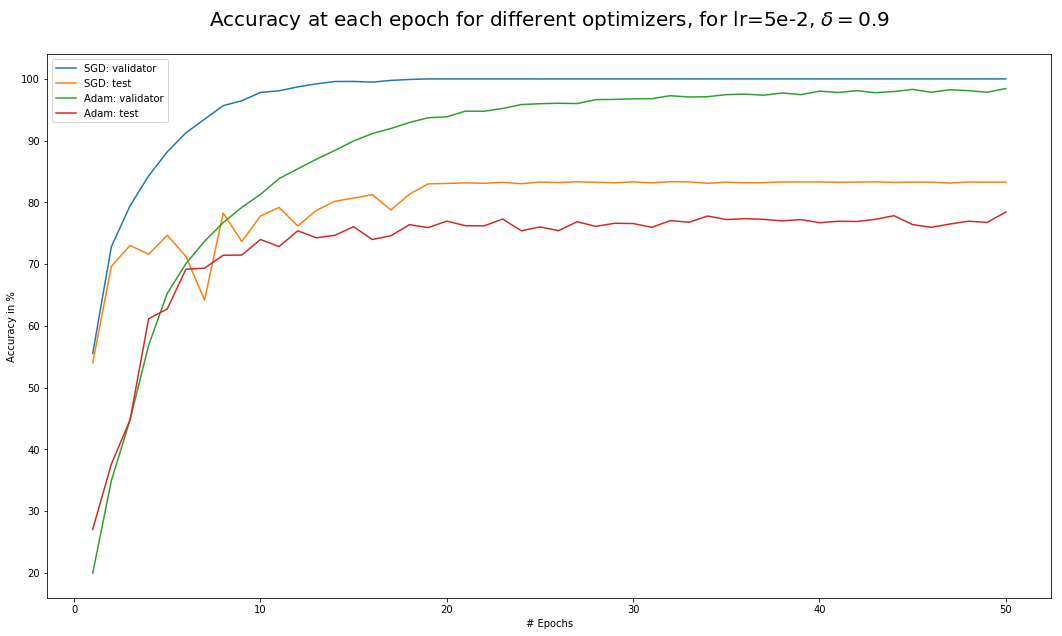

In [101]:
plt.figure(figsize = (18, 10))
plt.title('Accuracy at each epoch for different optimizers, for lr=5e-2, $\delta=0.9$\n',fontsize=20)
plt.xlabel('# Epochs')
plt.ylabel('Accuracy in %')
plt.plot(range(1,51), SGDacc__[0], antialiased=True, label='SGD: validator')
plt.plot(range(1,51), SGDacc__[1], antialiased=True, label='SGD: test')
plt.plot(range(1,51), Adamacc__[0], antialiased=True, label='Adam: validator')
plt.plot(range(1,51), Adamacc__[1], antialiased=True, label='Adam: test')
plt.legend()